# Clean Text Data

In [1]:
# # Check module locations if required
# import sys
# import pprint
# pprint.pprint(sys.path)

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import codecs
import io
from lxml import etree
from dateutil.relativedelta import *

import seaborn as sns; sns.set(style="darkgrid")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import re
import pickle
from tqdm.notebook import tqdm

import nltk

In [3]:
# Set display preference (Optional)
plt.rcParams["figure.figsize"] = (18,9)
plt.style.use('fivethirtyeight')

pd.options.display.max_rows = 20
pd.options.display.max_seq_items = 50
pd.set_option('display.max_colwidth', 200)

## Define Utility Functions

In [4]:
# Functions for map() or apply()

def get_word_count(x):
    '''
    Retun the number of words for the given text x.
    '''
    x = x.replace("[SECTION]", "")
    return len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', x))
        
def get_rate_change(x):
    '''
    Returns rate change decision of the FOMC Decision for the given date x.
    x should be of datetime type or yyyy-mm-dd format string.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strptime(x, '%Y-%m-%d')
        except:
            return None
    
    if x in fomc_calendar.index:
        return fomc_calendar.loc[x]['RateDecision']
    else:        
        return None

def get_rate(x):
    '''
    Returns rate of the FOMC Decision for the given date x.
    x should be of datetime type or yyyy-mm-dd format string.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strptime(x, '%Y-%m-%d')
        except:
            return None
        
    if x in fomc_calendar.index:
        return fomc_calendar.loc[x]['Rate']
    else:        
        return None

def get_next_meeting_date(x):
    '''
    Returns the next fomc meeting date for the given date x, referring to fomc_calendar DataFrame.
    Usually FOMC Meetings takes two days, so it starts searching from x+2.
    x should be of datetime type or yyyy-mm-dd format string.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strptime(x, '%Y-%m-%d')
        except:
            return None

    # Add two days to get the day after next
    x = x + dt.timedelta(days=2)
    
    # Just in case, sort fomc_calendar from older to newer
    fomc_calendar.sort_index(ascending=True, inplace=True)
    
    if fomc_calendar.index[0] > x:
        # If the date is older than the first FOMC Meeting, do not return any date.
        return None
    else:
        for i in range(len(fomc_calendar)):
            if x < fomc_calendar.index[i]:
                return fomc_calendar.index[i]
        # If x is greater than the newest FOMC meeting date, do not return any date.
        return None
    
def get_chairperson(x):
    '''
    Return a tuple of chairperson's Fullname for the given date x.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strftime(x, '%Y-%m-%d')
        except:
            return None
    
    chairperson = chairpersons.loc[chairpersons['FromDate'] <= x].loc[x <= chairpersons['ToDate']]
    return list(chairperson.FirstName)[0] + " " + list(chairperson.Surname)[0]

In [5]:
def reorganize_df(df, doc_type):
    '''
    Reorganize the loaded dataframe, which has been obrained by FomcGetData for further processing
        - Add type
        - Add word count
        - Add rate, decision (for meeting documents, None for the others)
        - Add next meeting date, rate and decision
        - Copy contents to org_text
        - Remove line breaks from contents in text
        - Split contents by "[SECTION]" to list in text_sections
    '''
    
    if doc_type in ('statement', 'minutes', 'presconf_script', 'meeting_script'):
        is_meeting_doc = True
    elif doc_type in ('speech', 'testimony'):
        is_meeting_doc = False
    else:
        print("Invalid doc_type [{}] is given!".format(doc_type))
        return None
    
    dict = {
        'type': doc_type,
        'date': df['date'],
        'title': df['title'],
        'speaker': df['speaker'],
        'word_count': df['contents'].map(get_word_count),
        'decision': df['date'].map(lambda x: get_rate_change(x) if is_meeting_doc else None),
        'rate': df['date'].map(lambda x: get_rate(x) if is_meeting_doc else None),
        'next_meeting': df['date'].map(get_next_meeting_date),
        'next_decision': df['date'].map(get_next_meeting_date).map(get_rate_change),
        'next_rate': df['date'].map(get_next_meeting_date).map(get_rate),        
        'text': df['contents'].map(lambda x: x.replace('\n','').replace('\r','').strip()),
        'text_sections': df['contents'].map(lambda x: x.replace('\n','').replace('\r','').strip().split("[SECTION]")),
        'org_text': df['contents']
    }

    new_df = pd.DataFrame(dict)
    new_df['decision'] = new_df['decision'].astype('Int8')
    new_df['next_decision'] = new_df['next_decision'].astype('Int8')
    print("No rate decision found: ", new_df['decision'].isnull().sum())
    print("Shape of the dataframe: ", new_df.shape)
    #new_df.dropna(subset=['decision'], axis=0, inplace=True)
    return new_df

In [6]:
# Split functions to process long text in machine learning based NLP

def get_split(text, split_len=200, overlap=50):
    '''
    Returns a list of split text of $split_len with overlapping of $overlap.
    Each item of the list will have around split_len length of text.
    '''
    l_total = []
    words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)
    
    if len(words) < split_len:
        n = 1
    else:
        n = (len(words) - overlap) // (split_len - overlap) + 1
        
    for i in range(n):
        l_parcial = words[(split_len - overlap) * i: (split_len - overlap) * i + split_len]
        l_total.append(" ".join(l_parcial))
    return l_total

def get_split_df(df, split_len=200, overlap=50):
    '''
    Returns a dataframe which is an extension of an input dataframe.
    Each row in the new dataframe has less than $split_len words in 'text'.
    '''
    split_data_list = []

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        #print("Original Word Count: ", row['word_count'])
        text_list = get_split(row["text"], split_len, overlap)
        for text in text_list:
            row['text'] = text
            #print(len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)))
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            split_data_list.append(list(row))
            
    split_df = pd.DataFrame(split_data_list, columns=df.columns)
    split_df['decision'] = split_df['decision'].astype('Int8')
    split_df['next_decision'] = split_df['next_decision'].astype('Int8')

    return split_df

In [7]:
def remove_short_section(df, min_words=50):
    '''
    Using 'text_sections' of the given dataframe, remove sections having less than min_words.
    It concatinate sections with a space, which exceeds min_words and update 'text'.
    As a fallback, keep a text which concatinates sections having more than 20 words and use it
     if there is no section having more than min_words.
    If there is no sections having more than 20 words, remove the row.
    '''
    new_df = df.copy()
    new_text_list = []
    new_text_section_list = []
    new_wc_list = []
    
    for i, row in tqdm(new_df.iterrows(), total=new_df.shape[0]):
        new_text = ""
        bk_text = ""
        new_text_section = []
        bk_text_section = []
                
        for section in row['text_sections']:
            num_words = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', section))
            if num_words > min_words:
                new_text += " " + section
                new_text_section.append(section)
            elif num_words > 20:
                bk_text += " " + section
                bk_text_section.append(section)
                
        
        new_text = new_text.strip()
        bk_text = bk_text.strip()
        
        if len(new_text) > 0:
            new_text_list.append(new_text)
            new_text_section_list.append(new_text_section)
        elif len(bk_text) > 0:
            new_text_list.append(bk_text)
            new_text_section_list.append(bk_text_section)
        else:
            new_text_list.append("")
            new_text_section_list.append("")
        
        # Update the word count
        new_wc_list.append(len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', new_text_list[-1])))
        
    new_df['text'] = new_text_list
    new_df['word_count'] = new_wc_list
    
    return new_df.loc[new_df['word_count'] > 0]

def remove_short_nokeyword(df, keywords = ['rate', 'rates', 'federal fund', 'outlook', 'forecast', 'employ', 'economy'], min_times=2, min_words=50):
    '''
    Drop sections which do not have any one of keywords for min_times times
     before applying remove_short_section()
    '''
    
    new_df = df.copy()
    new_section_list = []
    
    for i, row in tqdm(new_df.iterrows(), total=new_df.shape[0]):
        new_section = []
                
        for section in row['text_sections']:
            if len(set(section.split()).intersection(keywords)) >= min_times:
                new_section.append(section)
        
        new_section_list.append(new_section)
    
    new_df['text_sections'] = new_section_list
    
    return remove_short_section(new_df, min_words=min_words)

## Load Data

### Chairpersons

In [8]:
# FOMC Chairperson's list
chairpersons = pd.DataFrame(
    data=[["Volcker", "Paul", dt.datetime(1979,8,6), dt.datetime(1987,8,10)],
          ["Greenspan", "Alan", dt.datetime(1987,8,11), dt.datetime(2006,1,31)], 
          ["Bernanke", "Ben", dt.datetime(2006,2,1), dt.datetime(2014,1,31)], 
          ["Yellen", "Janet", dt.datetime(2014,2,3), dt.datetime(2018,2,3)],
          ["Powell", "Jerome", dt.datetime(2018,2,5), dt.datetime(2022,2,5)]],
    columns=["Surname", "FirstName", "FromDate", "ToDate"])
chairpersons

,Surname,FirstName,FromDate,ToDate
0,Volcker,Paul,1979-08-06,1987-08-10
1,Greenspan,Alan,1987-08-11,2006-01-31
2,Bernanke,Ben,2006-02-01,2014-01-31
3,Yellen,Janet,2014-02-03,2018-02-03
4,Powell,Jerome,2018-02-05,2022-02-05


### Load Calendar

In [9]:
file = open('../data/preprocessed/fomc_calendar.pickle', 'rb')

fomc_calendar = pickle.load(file)
file.close()

print(fomc_calendar.shape)
fomc_calendar

(403, 6)


,unscheduled,forecast,confcall,ChairPerson,Rate,RateDecision
date,,,,,,
1982-10-05,False,False,False,Paul Volcker,9.500,-1
1982-11-16,False,False,False,Paul Volcker,9.000,-1
1982-12-21,False,False,False,Paul Volcker,8.500,0
1983-01-14,False,False,True,Paul Volcker,8.500,0
1983-01-21,False,False,True,Paul Volcker,8.500,0
1983-01-28,False,False,True,Paul Volcker,8.500,0
1983-02-09,False,False,False,Paul Volcker,8.500,0
1983-03-29,False,False,False,Paul Volcker,8.625,1
1983-04-29,False,False,True,Paul Volcker,8.625,0


In [10]:
# #Check caleander
# fomc_calendar.loc[fomc_calendar.index >= dt.datetime(1998, 1, 27)]

### Statement

In [11]:
file = open('../data/FOMC/statement.pickle', 'rb')

statement_df = pickle.load(file)
file.close()

print(statement_df.shape)
statement_df

(197, 4)


,date,contents,speaker,title
0,1994-02-04,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...,Alan Greenspan,FOMC Statement
1,1994-03-22,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...,Alan Greenspan,FOMC Statement
2,1994-04-18,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...,Alan Greenspan,FOMC Statement
3,1994-05-17,\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...,Alan Greenspan,FOMC Statement
4,1994-08-16,\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...,Alan Greenspan,FOMC Statement
5,1994-11-15,"\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately.\n\n[SECTION]\n\nIn a related move, the Federal Op...",Alan Greenspan,FOMC Statement
6,1995-02-01,"\n\n[SECTION]\n\nFor immediate release\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 3/4 percent to 5 1/4 percent, effective immediately.\n\n[SEC...",Alan Greenspan,FOMC Statement
7,1995-07-06,\n\n[SECTION]\n\nFor immediate release\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to decrease slightly the degree of pressure on bank re...,Alan Greenspan,FOMC Statement
8,1995-12-19,\n\n[SECTION]\n\nFor immediate release\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to decrease slightly the degree of pressure on reserve...,Alan Greenspan,FOMC Statement
9,1996-01-31,For immediate release\n\n\n\n\n\n\r\n\r\nThe Federal Reserve today announced the following policy \r\nactions:\r\n\r\n\nThe Board of Governors approved a reduction in the discount rate from \r\n5-...,Alan Greenspan,FOMC Statement


In [12]:
# Sample Contents - the 2nd last
print(statement_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

### Meeting Minutes

In [13]:
file = open('../data/FOMC/minutes.pickle', 'rb')

minutes_df = pickle.load(file)
file.close()

print(minutes_df.shape)
minutes_df

(226, 4)


,date,contents,speaker,title
0,1993-02-03,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, February 2, 1993, at...",Alan Greenspan,FOMC Meeting Minutes
1,1993-03-23,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a...",Alan Greenspan,FOMC Meeting Minutes
2,1993-05-18,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, May 18, 1993, at ...",Alan Greenspan,FOMC Meeting Minutes
3,1993-07-07,"A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3...",Alan Greenspan,FOMC Meeting Minutes
4,1993-08-17,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ...",Alan Greenspan,FOMC Meeting Minutes
5,1993-09-21,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, September 21, 1993, ...",Alan Greenspan,FOMC Meeting Minutes
6,1993-11-16,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, November 16, 1993, a...",Alan Greenspan,FOMC Meeting Minutes
7,1993-12-21,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, December 21, 1993, at 9:...",Alan Greenspan,FOMC Meeting Minutes
8,1994-02-04,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Thursday, February 3, 1994, a...",Alan Greenspan,FOMC Meeting Minutes
9,1994-03-22,"A meeting of the Federal Open Market Committee was held in \n the offices of the Board of Governors of the Federal Reserve System in \n Washington, D.C., on Tuesday, March 22, 1994, at 9:00 a.m....",Alan Greenspan,FOMC Meeting Minutes


In [14]:
# Sample Contents - the 2nd last
print(minutes_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

### Meeting Transcripts

In [15]:
file = open('../data/FOMC/meeting_script.pickle', 'rb')

meeting_script_df = pickle.load(file)
file.close()

print(meeting_script_df.shape)
meeting_script_df

(200, 4)


,date,contents,speaker,title
0,1990-02-07,MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentleme...,Alan Greenspan,FOMC Meeting Transcript
1,1990-03-27,CHAIRMAN GREENSPAN. Governor LaWare has moved that it is agood morning. Are there any seconds?\n\n[SECTION]\n\nMR. JOHNSON. Second.\n\n[SECTION]\n\nSPEAKER(?). It's too early to ...,Alan Greenspan,FOMC Meeting Transcript
2,1990-05-15,CHAIRMAN GREENSPAN. Will someone move approval of theminutes of the March 27th meeting?\n\n[SECTION]\n\nMS. SEGER. I'll move them.\n\n[SECTION]\n\nMR. KELLEY. Second.\n\n[SECTION]\n\...,Alan Greenspan,FOMC Meeting Transcript
3,1990-07-03,"CHAIRMAN GREENSPAN. Can we get started, please? If somebodywould like to move approval of the minutes--\n\n[SECTION]\n\nVICE CHAIRMAN CORRIGAN. So move.\n\n[SECTION]\n\nSPEAKER(?). ...",Alan Greenspan,FOMC Meeting Transcript
4,1990-08-21,"CHAIRMAN GREENSPAN. Good morning, everyone. We'll startwith a controversial issue: approval of the minutes.\n\n[SECTION]\n\nSPEAKER(?). So move.\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. ...",Alan Greenspan,FOMC Meeting Transcript
5,1990-10-02,"CHAIRMAN GREENSPAN. Good morning, everyone. Would somebodykindly move the minutes of the last FOMC meeting?\n\n[SECTION]\n\nMS. SEGER. I'll move.\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Is ...",Alan Greenspan,FOMC Meeting Transcript
6,1990-11-13,CHAIRMAN GREENSPAN. Would somebody like to move approval ofthe minutes?\n\n[SECTION]\n\nMS. SEGER. I'll move.\n\n[SECTION]\n\nSPEAKER(?). Second.\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. No...,Alan Greenspan,FOMC Meeting Transcript
7,1990-12-18,CHAIRMAN GREENSPAN. Would somebody like to move the minutesof the previous meeting?\n\n[SECTION]\n\nVICE CHAIRMAN CORRIGAN. So move.\n\n[SECTION]\n\nMR. SYRON. Second.\n\n[SECTION]\...,Alan Greenspan,FOMC Meeting Transcript
8,1991-02-06,"CHAIRMAN GREENSPAN. Good afternoon, everyone. Welcome, BobMcTeer; it's nice to see you at the table. You're sitting between twoformidable characters but I suspect you'll surviv...",Alan Greenspan,FOMC Meeting Transcript
9,1991-03-26,"CHAIRMAN GREENSPAN. This is the first time in a long timethat [the Committee membership] has been addressed as ""Messrs."" Whowould like to move approval of the minutes?\n\n[SECTIO...",Alan Greenspan,FOMC Meeting Transcript


In [16]:
# Sample Contents - the 2nd last
print(meeting_script_df['contents'].iloc[-1])

CHAIR YELLEN.  Good afternoon, everyone.  I think we are ready to begin.  The first item we are going to consider is in a joint Board and FOMC meeting, so I need a motion to close the Board meeting. 

[SECTION]

MR. FISCHER.  So moved. 

[SECTION]

CHAIR YELLEN.  Without objection, thank you.  I’m going to start off by calling on Simon to give us his report on market developments. 

[SECTION]

MR. POTTER.1  Thank you, Madam Chair.  Lorie and I will be splitting the Desk briefing into two parts.  I will discuss financial market developments and some issues related to open market operations.  After questions and answers on this section, Lorie will discuss testing and some related issues with supplementary normalization tools. Over the intermeeting period, U.S. economic data were generally viewed as positive and changes in financial conditions were mixed.  International developments were in focus with more-accommodative policy adopted or communicated by major central banks, driven by conc

### Press Conference Transcripts

In [17]:
file = open('../data/FOMC/presconf_script.pickle', 'rb')

presconf_script_df = pickle.load(file)
file.close()

print(presconf_script_df.shape)
presconf_script_df

(43, 4)


,date,contents,speaker,title
0,2011-04-27,"CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl...",Ben Bernanke,FOMC Press Conference Transcript
1,2011-06-22,"CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections ...",Ben Bernanke,FOMC Press Conference Transcript
2,2011-11-02,"CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take...",Ben Bernanke,FOMC Press Conference Transcript
3,2012-01-25,CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals a...,Ben Bernanke,FOMC Press Conference Transcript
4,2012-04-25,"CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in th...",Ben Bernanke,FOMC Press Conference Transcript
5,2012-06-20,"CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then place the Committee’s appropriate path of moneta...",Ben Bernanke,FOMC Press Conference Transcript
6,2012-09-13,CHAIRMAN BERNANKE. Good afternoon. Earlier today the Federal Open Market Committee (FOMC) approved new measures to support the recovery and employment growth. I’ll get to the specifics of our a...,Ben Bernanke,FOMC Press Conference Transcript
7,2012-12-12,"CHAIRMAN BERNANKE. Good afternoon. It’s been about three and a half years since the economic recovery began. The economy continues to expand at a moderate pace. Unfortunately, however, unemplo...",Ben Bernanke,FOMC Press Conference Transcript
8,2013-03-20,"CHAIRMAN BERNANKE. Good afternoon. The Federal Open Market Committee concluded a two-day meeting earlier today. As always, my colleagues and I reviewed recent economic and financial developmen...",Ben Bernanke,FOMC Press Conference Transcript
9,2013-06-19,"CHAIRMAN BERNANKE. Good afternoon. The Federal Open Market Committee concluded a two-day meeting earlier today. Based on its review of recent economic and financial developments, the Committee...",Ben Bernanke,FOMC Press Conference Transcript


In [18]:
# Sample Contents - the 2nd last
print(presconf_script_df['contents'].iloc[-1])

CHAIR POWELL.  Good afternoon.  Thanks for joining us today.  I would like to begin by acknowledging the tragic loss and tremendous hardship that people are experiencing both here in the United States and around the world.  The coronavirus outbreak is first and foremost a public health crisis, and the most important response is coming from those in the front lines in hospitals, emergency services, and care facilities.  On behalf of the Federal Reserve, let me express our sincere gratitude to those dedicated individuals who put themselves at risk, day after day, in service to others and to our nation. The forceful measures that we as a country are taking to control the spread of the virus have brought much of the economy to an abrupt halt.  Many businesses have closed, people have been asked to stay home, and basic social interactions are greatly curtailed.  People are putting their lives and livelihoods on hold, at significant economic and personal cost.  All of us are affected, but th

### Speech

In [19]:
file = open('../data/FOMC/speech.pickle', 'rb')

speech_df = pickle.load(file)
file.close()

print(speech_df.shape)
speech_df

(1461, 4)


,date,contents,speaker,title
0,1996-06-13,"Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\...",Chairman Alan Greenspan,Bank supervision in a world economy
1,1996-06-18,"Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt i...","Governor Edward W. Kelley, Jr.",Developments in electronic money and banking
2,1996-09-08,Monetary Policy Objectives and Strategy\n\n[SECTION]\n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I al...,Governor Laurence H. Meyer,Monetary policy objectives and strategy
3,1996-09-19,"Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1...",Chairman Alan Greenspan,Regulation and electronic payment systems
4,1996-10-02,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nSmall Business Is Big Business\n\n[S...",Governor Lawrence B. Lindsey,Small business is big business
5,1996-10-05,"Remarks by Chairman Alan Greenspan\nBank supervision, regulation, and risk\r\nAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii \r\nOctober 5, 1996\n\n[SECTION]\n\n\n\...",Chairman Alan Greenspan,"Bank supervision, regulation, and risk"
6,1996-10-07,"Remarks by Chairman Alan Greenspan\nU.S. Treasury securities market: Lessons from Alexander Hamilton\r\nAt the Annual Public Service Awards Dinner of the Public Securities Association, New York, N...",Chairman Alan Greenspan,U.S. Treasury securities market: Lessons from Alexander Hamilton
7,1996-10-09,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Community Development Lending Conference, Dallas, Texas\r\nOctober 9, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nHere We Go Again?\n\n[SECTION]\n\nThan...",Governor Lawrence B. Lindsey,Here we go again?
8,1996-10-11,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Atlantic Economic Society, Washington, D.C.\r\nOctober 11, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nHow To Grow Faster\n\n[SECTION]\n\nIt is my pleas...",Governor Lawrence B. Lindsey,How to grow faster
9,1996-10-16,"Remarks by Chairman Alan Greenspan\nTechnological advances and productivity\r\nAt the 80th Anniversary Awards Dinner of The Conference Board, New York, New York\r\nOctober 16, 1996\n\n[SECTION]\n\...",Chairman Alan Greenspan,Technological advances and productivity


In [20]:
# Sample Contents - the 2nd last
print(speech_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

### Testimony

In [21]:
file = open('../data/FOMC/testimony.pickle', 'rb')

testimony_df = pickle.load(file)
file.close()

print(testimony_df.shape)
testimony_df

(436, 4)


,date,contents,speaker,title
0,1996-06-26,\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt is a pleasure to appear before this Subcommittee to discuss\r\n\r\n the supervision of bank sales practices on behalf of ...,"Governor Edward W. Kelley, Jr.",Supervision of bank sales practices
1,1996-07-17,"\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before the Committee on Banking, Housing,\r\n\r\n and Urban Affairs to discuss actions that the Feder...","Herbert A. Biern, Deputy Associate Director, Division of Banking Supervision and Regulation","""Prime bank"" schemes"
2,1996-07-18,"Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT...",Chairman Alan Greenspan,The Federal Reserve's semiannual monetary report
3,1996-07-24,\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before this Subcommittee today to discuss trends\r\n\r\nin consumer lending and the Federal Reserve Board...,Governor Janet L. Yellen,Trends in consumer lending
4,1996-07-26,\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI appreciate this opportunity to appear before the Banking Committee\r\n\r\ntoday to address certain recent reports on the Feder...,Chairman Alan Greenspan,Recent reports on Federal Reserve operations
5,1996-09-12,"\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before this Committee today to discuss trends in consumer\r\n\r\nlending, the Federal Reserve Board's vie...",Governor Lawrence B. Lindsey,Trends in consumer lending
6,1996-09-18,\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nThank you for the opportunity to discuss the recent trading losses by Sumitomo Corporation and their implications for U.S. banks and markets. T...,Governor Susan M. Phillips,Implications of trading losses by Sumitomo Corp.
7,1997-01-21,"Testimony of Chairman Alan Greenspan\nPerformance of the U.S. economy\r\nBefore the Committee on the Budget, United States Senate\r\nJanuary 21, 1997\n\n[SECTION]\n\nMr. Chairman and members of th...",Chairman Alan Greenspan,"January 21, 1997"
8,1997-01-30,"Testimony of Chairman Alan Greenspan\nThe consumer price index\r\nBefore the Committee on Finance, United States Senate\r\nJanuary 30, 1997\n\n[SECTION]\n\nMr. Chairman and members of the Committe...",Chairman Alan Greenspan,The comsumer price index
9,1997-02-13,Testimony of Chairman Alan Greenspan\nModernization of the financial system\r\nBefore the Subcommittee on Financial Institutions and Consumer Credit\r\n\tof the Committee on Banking and Financial ...,Chairman Alan Greenspan,Modernization of the financial system


In [22]:
# Sample Contents - the 2nd last
print(testimony_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

## Statements DataFrame

In [23]:
statement_df.head()

,date,contents,speaker,title
0,1994-02-04,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...,Alan Greenspan,FOMC Statement
1,1994-03-22,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...,Alan Greenspan,FOMC Statement
2,1994-04-18,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...,Alan Greenspan,FOMC Statement
3,1994-05-17,\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...,Alan Greenspan,FOMC Statement
4,1994-08-16,\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...,Alan Greenspan,FOMC Statement


### Add Quantitative Easing as a Lower event

In [24]:
# Add When QE was first announced on 2008-11-25. No statemenet on that day.

if statement_df.loc[statement_df['date'] == dt.datetime.strptime('2008-11-25', '%Y-%m-%d')].shape[0] == 0:
    qe_text = "The Federal Reserve announced on Tuesday that it will initiate a program "\
              "to purchase the direct obligations of housing-related government-sponsored "\
              "enterprises (GSEs)--Fannie Mae, Freddie Mac, and the Federal Home Loan Banks "\
              "--and mortgage-backed securities (MBS) backed by Fannie Mae, Freddie Mac, "\
              "and Ginnie Mae.  Spreads of rates on GSE debt and on GSE-guaranteed mortgages "\
              "have widened appreciably of late.  This action is being taken to reduce the cost "\
              "and increase the availability of credit for the purchase of houses, which in turn "\
              "should support housing markets and foster improved conditions in financial markets "\
              "more generally. Purchases of up to $100 billion in GSE direct obligations under "\
              "the program will be conducted with the Federal Reserve's primary dealers through "\
              "a series of competitive auctions and will begin next week.  Purchases of up to "\
              "$500 billion in MBS will be conducted by asset managers selected via a competitive "\
              "process with a goal of beginning these purchases before year-end.  "\
              "Purchases of both direct obligations and MBS are expected to take place over "\
              "several quarters.  Further information regarding the operational details of this "\
              "program will be provided after consultation with market participants."
    statement_df = statement_df.append(
        pd.Series([dt.datetime.strptime('2008-11-25', '%Y-%m-%d'), qe_text, 'Ben Bernanke', 'FOMC statement'], index=statement_df.columns),
        ignore_index=True
    )
    

### Process the dataframe

In [25]:
# Reorganize the dataframe
proc_statement_df = reorganize_df(statement_df, 'statement')

No rate decision found:  1
Shape of the dataframe:  (198, 13)


In [26]:
# Check the returned dataframe
proc_statement_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,[SECTION]Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be assoc...,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated ...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.50,1994-04-18,1,3.75,[SECTION]Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be asso...,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,[SECTION]Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small ...,"[, Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increa...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,160,1,4.25,1994-07-06,0,4.25,[SECTION]The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.[SECTION]The Board approved an increase in th...,"[, The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion., The Board approved an increase in the discount ra...",\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,137,1,4.75,1994-09-27,0,4.75,[SECTION]The Federal Reserve announced today the following monetary policy actions:[SECTION]These measures were taken against the background of evidence of continuing strength in the economic expa...,"[, The Federal Reserve announced today the following monetary policy actions:, These measures were taken against the background of evidence of continuing strength in the economic expansion and hig...",\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...
5,statement,1994-11-15,FOMC Statement,Alan Greenspan,139,1,5.50,1994-12-20,0,5.50,"[SECTION]The Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately.[SECTION]In a related move, the Federal Open Market Commit...","[, The Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately., In a related move, the Federal Open Market Commit

In [27]:
# Check which row does not have rate
proc_statement_df.loc[proc_statement_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
196,statement,2020-06-10,FOMC Statement,Jerome Powell,583,NaN,NaN,2020-07-29,NaN,NaN,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."


In [28]:
x = dt.datetime.strptime('2019-01-01', '%Y-%m-%d')
fomc_calendar.loc[fomc_calendar.index > x]

,unscheduled,forecast,confcall,ChairPerson,Rate,RateDecision
date,,,,,,
2019-01-30,False,False,False,Jerome Powell,2.25,0
2019-03-20,False,True,False,Jerome Powell,2.25,0
2019-05-01,False,False,False,Jerome Powell,2.25,0
2019-06-19,False,True,False,Jerome Powell,2.25,0
2019-07-31,False,False,False,Jerome Powell,2.00,-1
2019-09-18,False,True,False,Jerome Powell,1.75,-1
2019-10-04,True,False,False,Jerome Powell,1.75,0
2019-10-30,False,False,False,Jerome Powell,1.50,-1
2019-12-11,False,True,False,Jerome Powell,1.50,0


In [29]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
proc_statement_df = remove_short_section(proc_statement_df, min_words=50)
proc_statement_df


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated wit...,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated ...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.50,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated wi...,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increase ...,"[, Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increa...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board approved requests submitted by the Boards of Directors of eleven Federal Reserve Banks -- Boston, New York, Philadelphia, Richmond, Atlanta, Chicago, St. L...","[, The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion., The Board approved an increase in the discount ra...",\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board approved requests submitted by the Boards of Directors of the Federal Reserve Banks of Boston, New York, Richmond, Kansas City, and Dallas. The discou...","[, The Federal Reserve announced today the following monetary policy actions:, These measures were taken against the background of evidence of continuing strength in the economic expansion and hig...",\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...
5,statement,1994-11-15,FOMC Statement,Alan Greenspan,121,1,5.50,1994-12-20,0,5.50,"In a related move, the Federal Open Market Committee decided that the increase in the discount rate should be reflected fully in interest rates in reserve markets. These measures were taken agains...","[, The Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately., In a related move, the Federal Open Market Comm

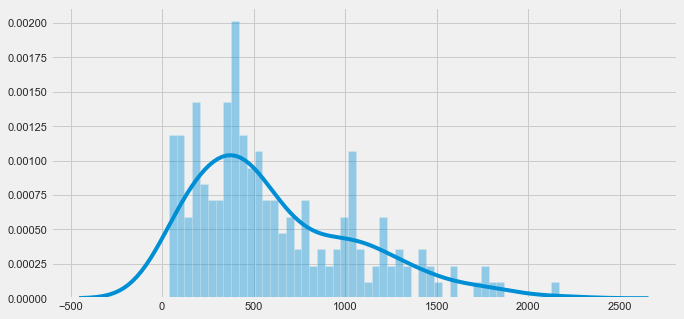

In [30]:
plt.figure(figsize=(10,5))
sns.distplot(proc_statement_df["word_count"].values, bins=50)

### Split contents to max 200 words

In [31]:
split_statement_df = get_split_df(proc_statement_df)
split_statement_df.tail(10)

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
843,statement,2020-03-23,FOMC Statement,Jerome Powell,88,0,0.0,2020-03-31,0,0.0,of Treasury securities held outright in the System Open Market Account that are available for such operations and by a per counterparty limit of billion per day The Committee directs the Desk to c...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
844,statement,2020-03-31,FOMC Statement,Jerome Powell,200,0,0.0,2020-04-29,0,0.0,The Federal Reserve on Tuesday announced the establishment of a temporary repurchase agreement facility for foreign and international monetary authorities FIMA Repo Facility to help support the sm...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
845,statement,2020-03-31,FOMC Statement,Jerome Powell,99,0,0.0,2020-04-29,0,0.0,securities in the open market It should also serve along with the U S dollar liquidity swap lines the Federal Reserve has established with other central banks to help ease strains in global U S do...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
846,statement,2020-04-29,FOMC Statement,Jerome Powell,200,0,0.0,2020-06-10,NaN,NaN,The coronavirus outbreak is causing tremendous human and economic hardship across the United States and around the world The virus and the measures taken to protect public health are inducing shar...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
847,statement,2020-04-29,FOMC Statement,Jerome Powell,200,0,0.0,2020-06-10,NaN,NaN,and is on track to achieve its maximum employment and price stability goals The Committee will continue to monitor the implications of incoming information for the economic outlook including infor...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
848,statement,2020-04-29,FOMC Statement,Jerome Powell,54,0,0.0,2020-06-10,NaN,NaN,in the amounts needed to support smooth market functioning thereby fostering effective transmission of monetary policy to broader financial conditions In addition the Open Market Desk will continu...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committe

### Filter out by keywords

In [32]:
# Keep sections having keywords and long enough
keyword_statement_df = remove_short_nokeyword(proc_statement_df)
keyword_statement_df.reset_index(drop=True, inplace=True)
print(keyword_statement_df.shape)
keyword_statement_df


(105, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,statement,1994-05-17,FOMC Statement,Alan Greenspan,38,1,4.25,1994-07-06,0,4.25,"The Board approved an increase in the discount rate from 3 percent to 3-1/2 percent, effective immediately, and the Federal Open Market Committee agreed that this increase should be allowed to sho...","[The Board approved an increase in the discount rate from 3 percent to 3-1/2 percent, effective immediately, and the Federal Open Market Committee agreed that this increase should be allowed to sh...",\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...
1,statement,1994-11-15,FOMC Statement,Alan Greenspan,27,1,5.50,1994-12-20,0,5.50,"In a related move, the Federal Open Market Committee decided that the increase in the discount rate should be reflected fully in interest rates in reserve markets.","[In a related move, the Federal Open Market Committee decided that the increase in the discount rate should be reflected fully in interest rates in reserve markets.]","\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately.\n\n[SECTION]\n\nIn a related move, the Federal Op..."
2,statement,1996-01-31,FOMC Statement,Alan Greenspan,391,-1,5.25,1996-03-26,0,5.25,"For immediate releaseThe Federal Reserve today announced the following policy actions:The Board of Governors approved a reduction in the discount rate from 5-1/4 percent to 5 percent, effective im...","[For immediate releaseThe Federal Reserve today announced the following policy actions:The Board of Governors approved a reduction in the discount rate from 5-1/4 percent to 5 percent, effective i...",For immediate release\n\n\n\n\n\n\r\n\r\nThe Federal Reserve today announced the following policy \r\nactions:\r\n\r\n\nThe Board of Governors approved a reduction in the discount rate from \r\n5-...
3,statement,1997-03-25,FOMC Statement,Alan Greenspan,405,1,5.50,1997-05-20,0,5.50,"For immediate release\tThe Federal Open Market Committee decided today to tighten money market conditions slightly, expecting the federal funds rate to rise 1/4 percentage point to around 5-1/2 pe...","[For immediate release\tThe Federal Open Market Committee decided today to tighten money market conditions slightly, expecting the federal funds rate to rise 1/4 percentage point to around 5-1/2 p...","For immediate release\n\n\n\n\n\n\r\n\r\n\tThe Federal Open Market Committee decided today to tighten money market conditions slightly, expecting the federal funds rate to rise 1/4 percentage poin..."
4,statement,1998-09-29,FOMC Statement,Alan Greenspan,373,-1,5.25,1998-10-15,-1,5.00,"For immediate releaseThe Federal Open Market Committee decided today to ease the stance of monetary policy slightly, expecting the federal funds rate to decline 1/4 percentage point to around 5-1/...","[For immediate releaseThe Federal Open Market Committee decided today to ease the stance of monetary policy slightly, expecting the federal funds rate to decline 1/4 percentage point to around 5-1...","For immediate release\n\n\n\n\n\n\r\nThe Federal Open Market Committee decided today to ease the stance of monetary policy slightly, expecting the federal funds rate to decline 1/4 percentage poin..."
5,statement,1999-06-30,FOMC Statement,Alan Greenspan,477,1,5.00,1999-08-24,1,5.25,For immediate release\tThe Federal Open Market Committee today voted to raise its target for the federal funds rate 25 basis points to 5 percent. Last fall the Committee reduced interest rates to...,[For immediate release\tThe Federal Open Market Committee today voted to raise its target for the federal funds rate 25 basis points to 5 percent. Last fall the Committee reduced interest rates t...,For immediate release\n\n\n\n\n\n\r\n\

In [33]:
# Drop text during the process to reduce the output size
proc_statement_df.drop(columns=['text_sections', 'org_text'], inplace=True)
split_statement_df.drop(columns=['text_sections', 'org_text'], inplace=True)
keyword_statement_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Minutes DataFrame

In [34]:
minutes_df.head()

,date,contents,speaker,title
0,1993-02-03,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, February 2, 1993, at...",Alan Greenspan,FOMC Meeting Minutes
1,1993-03-23,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a...",Alan Greenspan,FOMC Meeting Minutes
2,1993-05-18,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, May 18, 1993, at ...",Alan Greenspan,FOMC Meeting Minutes
3,1993-07-07,"A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3...",Alan Greenspan,FOMC Meeting Minutes
4,1993-08-17,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ...",Alan Greenspan,FOMC Meeting Minutes


In [35]:
# Reorganize the dataframe
proc_minutes_df = reorganize_df(minutes_df, 'minutes')

No rate decision found:  0
Shape of the dataframe:  (226, 13)


In [36]:
# Check the returned dataframe
proc_minutes_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,minutes,1993-02-03,FOMC Meeting Minutes,Alan Greenspan,10241,0,3.00,1993-02-18,0,3.00,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, February 2, 1993, at 2:30 p....","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, February 2, 1993, at 2:30 p...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, February 2, 1993, at..."
1,minutes,1993-03-23,FOMC Meeting Minutes,Alan Greenspan,5792,0,3.00,1993-05-18,0,3.00,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, March 23, 1993, at 9:00 ...","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, March 23, 1993, at 9:00...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a..."
2,minutes,1993-05-18,FOMC Meeting Minutes,Alan Greenspan,5001,0,3.00,1993-07-07,0,3.00,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, May 18, 1993, at 9:00 a....","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, May 18, 1993, at 9:00 a...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, May 18, 1993, at ..."
3,minutes,1993-07-07,FOMC Meeting Minutes,Alan Greenspan,7064,0,3.00,1993-08-17,0,3.00,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, July 6, 1993, at 2:30 p.m. a...","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, July 6, 1993, at 2:30 p.m. ...","A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3..."
4,minutes,1993-08-17,FOMC Meeting Minutes,Alan Greenspan,4679,0,3.00,1993-09-21,0,3.00,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, August 17, 1993, at 9:00 a.m...","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, August 17, 1993, at 9:00 a....","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ..."
5,minutes,1993-09-21,FOMC Meeting Minutes,Alan Greenspan,4995,0,3.00,1993-10-05,0,3.00,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, September 21, 1993, at 9:00 ...","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, September 21, 1993, at 9:00...","A meeting of the Federal Open Market Committee was held in \r\n the offices

In [37]:
# Check which row does not have rate
proc_minutes_df.loc[proc_minutes_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text


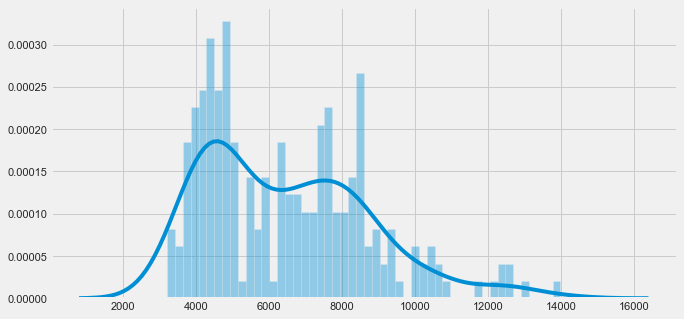

In [38]:
plt.figure(figsize=(10,5))
sns.distplot(proc_minutes_df["word_count"].values, bins=50)

In [39]:
# Check which row does not have rate
proc_minutes_df.loc[proc_minutes_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text


Meeting minutes includes various topics, so it makes sense to extract relevant sections. <br />
Check some common sections.

In [40]:
# Check what kind of sections are in common

a = minutes_df.contents.str.lower().str.count('staff economic outlook')
b = minutes_df.contents.str.lower().str.count('developments in financial markets')
c = minutes_df.contents.str.lower().str.count('staff review of the economic situation')
d = minutes_df.contents.str.lower().str.count('staff review of the financial situation')
e = minutes_df.contents.str.lower().str.count('participants\' views on current condition')
f = minutes_df.contents.str.lower().str.count('committee policy action')
g = minutes_df.contents.str.lower().str.count('voting for this action')
h = minutes_df.contents.str.lower().str.count('federal fund')

pd.options.display.max_rows = 300
pd.DataFrame({'date': minutes_df['date'], 'a': a, 'b':b, 'c':c, 'd':d, 'e':e, 'f':f, 'g':g, 'h':h})

,date,a,b,c,d,e,f,g,h
0,1993-02-03,0,0,0,0,0,0,0,1
1,1993-03-23,0,0,0,0,0,0,0,3
2,1993-05-18,0,0,0,0,0,0,0,1
3,1993-07-07,0,0,0,0,0,0,0,3
4,1993-08-17,0,0,0,0,0,0,0,1
5,1993-09-21,0,0,0,0,0,0,0,1
6,1993-11-16,0,0,0,0,0,0,0,1
7,1993-12-21,0,0,0,0,0,0,0,2
8,1994-02-04,0,1,0,0,0,0,0,0
9,1994-03-22,0,0,0,0,0,0,0,2


In [41]:
pd.options.display.max_rows = 20

Sections are added from time to time. For example, quarterly economic forcast started in 2009. Leave manually handling those for now, take another approach to filter sentenses by length and key words here.

In [42]:
proc_minutes_df = remove_short_section(proc_minutes_df, min_words=50)

### Split contents to max 200 words

In [43]:
split_minutes_df = get_split_df(proc_minutes_df)
print(split_minutes_df.shape)
split_minutes_df.tail(10)


(8369, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
8359,minutes,2020-04-29,FOMC Meeting Minutes,Jerome Powell,200,0,0.0,2020-06-10,NaN,NaN,this challenging time thereby promoting its maximum employment and price stability goals In light of their assessment that the ongoing public health crisis would weigh heavily on economic activity...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
8360,minutes,2020-04-29,FOMC Meeting Minutes,Jerome Powell,200,0,0.0,2020-06-10,NaN,NaN,stability goals Participants also assessed that it was appropriate for the Federal Reserve to continue to purchase Treasury securities and agency residential mortgage backed securities RMBS and CM...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
8361,minutes,2020-04-29,FOMC Meeting Minutes,Jerome Powell,200,0,0.0,2020-06-10,NaN,NaN,supporting financial market functioning and the flow of credit to households businesses of all sizes and state and local governments In this way these emergency lending facilities were intended to...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
8362,minutes,2020-04-29,FOMC Meeting Minutes,Jerome Powell,200,0,0.0,2020-06-10,NaN,NaN,of the unemployment rate or of the inflation that must be achieved before the Committee would consider raising the target range for the federal funds rate The Committee could also consider date ba...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
8363,minutes,2020-04-29,FOMC Meeting Minutes,Jerome Powell,200,0,0.0,2020-06-10,NaN,NaN,MBS these participants noted that without further communication on this matter uncertainty about the evolution of the Federal Reserve's asset purchases could increase over time Several participant...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
8364,minutes,2020-04-29,FOMC Meeting Minutes,Jerome Powell,200,0,0.0,2020-06-10,NaN,NaN,declines in economic activity and a surge in job losses Consumer price inflation was being held down by weaker demand and significantly lower oil prices The disruptions to global economic activity...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financia

### Filter out by keywords

In [44]:
# Keep sections having keywords and long enough
keyword_minutes_df = remove_short_nokeyword(proc_minutes_df)
keyword_minutes_df.reset_index(drop=True, inplace=True)
print(keyword_minutes_df.shape)
keyword_minutes_df


(226, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,minutes,1993-02-03,FOMC Meeting Minutes,Alan Greenspan,2119,0,3.00,1993-02-18,0,3.00,"The nominal U.S. merchandise trade deficit widened slightly in November. For October and November together, however, the deficit narrowed a little from its average rate in the third quarte...","[The nominal U.S. merchandise trade deficit widened slightly in November. For October and November together, however, the deficit narrowed a little from its average rate in the third quart...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, February 2, 1993, at..."
1,minutes,1993-03-23,FOMC Meeting Minutes,Alan Greenspan,1770,0,3.00,1993-05-18,0,3.00,"In foreign exchange markets, the trade-weighted value of the dollar in terms of the other G-10 currencies fell on balance over the intermeeting period. The dollar depreciated through late ...","[In foreign exchange markets, the trade-weighted value of the dollar in terms of the other G-10 currencies fell on balance over the intermeeting period. The dollar depreciated through late...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a..."
2,minutes,1993-05-18,FOMC Meeting Minutes,Alan Greenspan,1182,0,3.00,1993-07-07,0,3.00,"In foreign exchange markets, the trade-weighted value of the dollar in terms of the other G-10 currencies declined somewhat on balance over the intermeeting period. The dollar depreciated ...","[In foreign exchange markets, the trade-weighted value of the dollar in terms of the other G-10 currencies declined somewhat on balance over the intermeeting period. The dollar depreciated...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, May 18, 1993, at ..."
3,minutes,1993-07-07,FOMC Meeting Minutes,Alan Greenspan,2636,0,3.00,1993-08-17,0,3.00,"Other short-term interest rates also were little changed on balance over the period since the May meeting. Early in the period, unexpectedly robust employment data for May, coupled with me...","[Other short-term interest rates also were little changed on balance over the period since the May meeting. Early in the period, unexpectedly robust employment data for May, coupled with m...","A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3..."
4,minutes,1993-08-17,FOMC Meeting Minutes,Alan Greenspan,1272,0,3.00,1993-09-21,0,3.00,"Money market interest rates were little changed on balance over the intermeeting period, while rates on intermediate-term U.S. Treasury obligations and on fixed-rate mortgages dropped slig...","[Money market interest rates were little changed on balance over the intermeeting period, while rates on intermediate-term U.S. Treasury obligations and on fixed-rate mortgages dropped sli...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ..."
5,minutes,1993-09-21,FOMC Meeting Minutes,Alan Greenspan,699,0,3.00,1993-10-05,0,3.00,"The information reviewed by the Committee at this meeting suggested that economic activity, adjusted for the temporary depressing effects of the flood in the Midwest, was continuing to ...","[The information reviewed by the Committee at this meeting suggested that economic activity, adjusted for the temporary depressing effects of the flood in the Midwest, was continuing to ...","A meeting of the Federal Open Market Committee was held in \r\n th

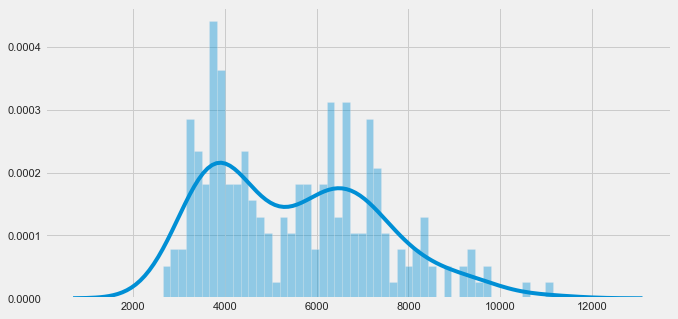

In [45]:
plt.figure(figsize=(10,5))
sns.distplot(proc_minutes_df["word_count"].values, bins=50)

In [46]:
# Drop text during the process to reduce the output size
proc_minutes_df.drop(columns=['text_sections', 'org_text'], inplace=True)
split_minutes_df.drop(columns=['text_sections', 'org_text'], inplace=True)
keyword_minutes_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Press Conference Script DataFrame
Press Conference transcripts are available only from 2011

In [47]:
# Sample
print(presconf_script_df['contents'][2])

CHAIRMAN BERNANKE.  Good afternoon, everybody.  Welcome.  In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy.  I will then be glad to take your questions.   As indicated in its statement, the Committee decided today to maintain the policies that were initiated at previous meetings.  In particular, the Committee is keeping the target range for the federal funds rate at 0 to ¼ percent and continues to anticipate that economic conditions are likely to warrant exceptionally low levels for the federal funds rate at least through mid-2013. The Committee will continue the program that we announced in September to extend the average maturity of the Federal Reserve’s holdings of securities by purchasing longer-term Treasury securities and selling an equal amount of shorter-term Treasury securities.  Our purchases of longer-term securities exert downward pressures on longer-term interest rates; at the same time, our guidance about the lik

In [48]:
# Reorganize the dataframe
proc_presconf_script_df = reorganize_df(presconf_script_df, 'presconf_script')


No rate decision found:  0
Shape of the dataframe:  (43, 13)


In [49]:
# Check the returned dataframe
proc_presconf_script_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,8763,0,0.00,2011-06-22,0,0.00,"CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
1,presconf_script,2011-06-22,FOMC Press Conference Transcript,Ben Bernanke,7364,0,0.00,2011-08-01,0,0.00,"CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections ...","[CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections...","CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections ..."
2,presconf_script,2011-11-02,FOMC Press Conference Transcript,Ben Bernanke,7360,0,0.00,2011-11-28,0,0.00,"CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take...","[CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to tak...","CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take..."
3,presconf_script,2012-01-25,FOMC Press Conference Transcript,Ben Bernanke,10135,0,0.00,2012-03-13,0,0.00,CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals a...,[CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals ...,CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals a...
4,presconf_script,2012-04-25,FOMC Press Conference Transcript,Ben Bernanke,7680,0,0.00,2012-06-20,-1,0.00,"CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in th...","[CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in t...","CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in th..."
5,presconf_script,2012-06-20,FOMC Press Conference Transcript,Ben Bernanke,7218,-1,0.00,2012-08-01,0,0.00,"CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then place the Committee’s appropriate path of moneta...","[CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize

In [50]:
# Check which row does not have rate
proc_presconf_script_df.loc[proc_presconf_script_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text


### Split by speakers
Scripts contain words from different people, so split by the speaker

In [51]:
script_data_list = []

for i, row in tqdm(proc_presconf_script_df.iterrows()):
    for text in row["text_sections"]:
        match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d? (.*)', text)
        if len(match) == 0:
            match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d(.*)', text)
            if len(match) == 0:
                print("not matched: ", text)
                print(row['date'])
                print()
        if len(match) == 1:
            speaker, text = match[0]
            row['speaker'] = speaker
            row['text'] = text
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            script_data_list.append(list(row))

col_name = proc_presconf_script_df.columns

presconf_script_speaker_df = pd.DataFrame(script_data_list, columns = col_name)
presconf_script_speaker_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,presconf_script,2011-04-27,FOMC Press Conference Transcript,CHAIRMAN BERNANKE,1617,0,0.0,2011-06-22,0.0,0.0,"Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterly economic projecti...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
1,presconf_script,2011-04-27,FOMC Press Conference Transcript,QUESTION,64,0,0.0,2011-06-22,0.0,0.0,"Mr. Chairman, tomorrow we’re going to get a pretty weak first-quarter GDP number. Your own projections for the year have been downgraded in this meeting. How—first of all, what do you see as th...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
2,presconf_script,2011-04-27,FOMC Press Conference Transcript,CHAIRMAN BERNANKE,198,0,0.0,2011-06-22,0.0,0.0,"You’re correct. We haven’t seen the GDP number yet. But we, like most private-sector forecasters, are expecting a relatively weak number for the first quarter, maybe something a little under 2 ...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
3,presconf_script,2011-04-27,FOMC Press Conference Transcript,QUESTION,56,0,0.0,2011-06-22,0.0,0.0,"Mr. Chairman, given what you know about the pace of the economy now, what is your best guess for how soon the Fed needs to begin to withdraw its extraordinary stimulus for the economy? And could...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
4,presconf_script,2011-04-27,FOMC Press Conference Transcript,CHAIRMAN BERNANKE,322,0,0.0,2011-06-22,0.0,0.0,"Well, currently as the statement suggests, we are in a moderate recovery. We’ll be looking very carefully, first, to see if that recovery is, indeed, sustainable, as we believe it is. And we’ll...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
5,presconf_script,2011-04-27,FOMC Press Conference Transcript,QUESTION,57,0,0.0,2011-06-22,0.0,0.0,"Mr. Chairman, first, thanks for doing this. This is a tremendous development. There are critics who say that Fed policy has driven down the value of the dollar, and a lower value to the dollar ...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to brief

In [52]:
# Filter by the word count
presconf_script_speaker_df = presconf_script_speaker_df.loc[presconf_script_speaker_df['word_count'] >= 50]

(1600, 13)


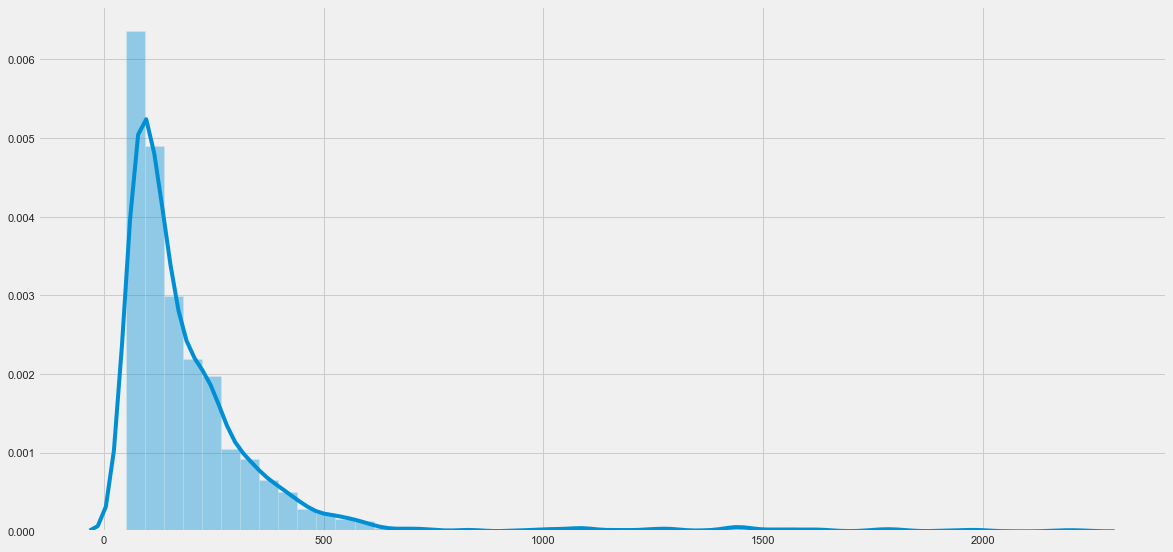

In [53]:
print(presconf_script_speaker_df.shape)
sns.distplot(presconf_script_speaker_df["word_count"].values, bins=50)

In [54]:
# Filter to have only chairperson's speak

tmp_list = []
for i, row in presconf_script_speaker_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson.lower().split()[-1] in row['speaker'].lower():
        row['speaker'] = chairperson
        tmp_list.append(list(row))

col_names = presconf_script_speaker_df.columns
presconf_script_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)
presconf_script_chair_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,1617,0,0.0,2011-06-22,0.0,0.0,"Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterly economic projecti...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
1,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,198,0,0.0,2011-06-22,0.0,0.0,"You’re correct. We haven’t seen the GDP number yet. But we, like most private-sector forecasters, are expecting a relatively weak number for the first quarter, maybe something a little under 2 ...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
2,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,322,0,0.0,2011-06-22,0.0,0.0,"Well, currently as the statement suggests, we are in a moderate recovery. We’ll be looking very carefully, first, to see if that recovery is, indeed, sustainable, as we believe it is. And we’ll...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
3,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,207,0,0.0,2011-06-22,0.0,0.0,"Thanks, Steve. First, I should start by saying that the Secretary of the Treasury, of course, is the spokesperson for U.S. policy on the dollar and Secretary Geithner had some words yesterday. ...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
4,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,167,0,0.0,2011-06-22,0.0,0.0,"Well, the dollar—the dollar fluctuates. One factor, for example, that has caused fluctuations that have been quite extreme during the crisis has been the safe-haven effect. So, for example, dur...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarter...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
5,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,511,0,0.0,2011-06-22,0.0,0.0,"Sure. Thanks, Jon. So, first of all, gasoline prices obviously have risen quite significantly. And we, of course, are watching that carefully, that higher gas prices are absolutely creating a ...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly

In [55]:
# Combine scripts of the same speaker for the same day.
tmp_date = ''
tmp_speaker = ''
tmp_data = []

print('Before: ', presconf_script_chair_df.shape)

for i, row in tqdm(presconf_script_chair_df.iterrows()):
    if (row['date'] == tmp_date) and (row['speaker'] == tmp_speaker):
        tmp_data[-1]['text'] += row['text']
        tmp_data[-1]['word_count'] += row['word_count']
        tmp_data[-1]['text_sections'].append(row['text'])
    else:
        tmp_date = row['date']
        tmp_speaker = row['speaker']
        row['text_sections'] = [row['text']]
        tmp_data.append(row)

presconf_script_chair_day_df = pd.DataFrame(tmp_data)

print('After', presconf_script_chair_day_df.shape)
presconf_script_chair_day_df.head()

Before:  (942, 13)



After (43, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,7504,0,0.0,2011-06-22,0.0,0.0,"Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterly economic projecti...","[ Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterly economic project...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
21,presconf_script,2011-06-22,FOMC Press Conference Transcript,Ben Bernanke,6002,0,0.0,2011-08-01,0.0,0.0,"Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections and our policy stra...","[ Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections and our policy str...","CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections ..."
40,presconf_script,2011-11-02,FOMC Press Conference Transcript,Ben Bernanke,5875,0,0.0,2011-11-28,0.0,0.0,"Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take your questions. ...","[ Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take your questions. ...","CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take..."
62,presconf_script,2012-01-25,FOMC Press Conference Transcript,Ben Bernanke,7970,0,0.0,2012-03-13,0.0,0.0,Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals and strategy. And f...,[ Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals and strategy. And ...,CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals a...
81,presconf_script,2012-04-25,FOMC Press Conference Transcript,Ben Bernanke,5854,0,0.0,2012-06-20,-1.0,0.0,"Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in the context of our ec...","[ Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in the context of our e...","CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in th..."


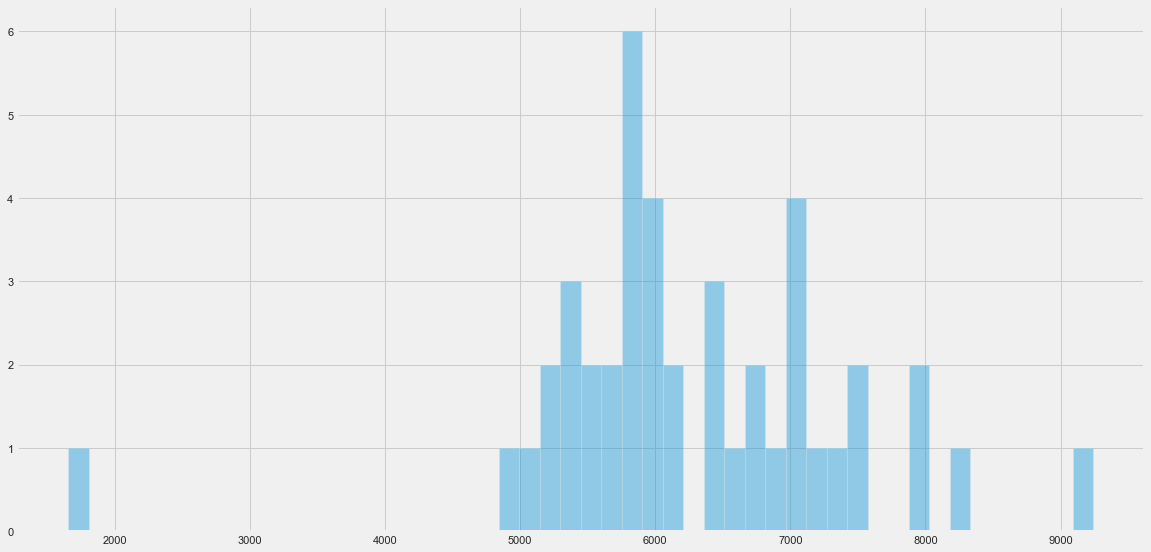

In [56]:
sns.distplot(list(presconf_script_chair_day_df['word_count']), bins=50, kde=False)

In [57]:
# # Check text
# print(presconf_script_chair_day_df['text'][0])

### Split contents to max 200 words

In [58]:
presconf_script_split_df = get_split_df(presconf_script_chair_day_df)
print(presconf_script_split_df.shape)
presconf_script_split_df.tail()


(1802, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
1797,presconf_script,2020-04-29,FOMC Press Conference Transcript,Jerome Powell,200,0,0.0,2020-06-10,NaN,NaN,the risk to of damage to people s skills and their careers and their lives is a function of time to some extent So the longer one is unemployed the harder it gets I think and we ve probably all se...,[ Good afternoon. Thanks for joining us today. I would like to begin by acknowledging the tragic loss and tremendous hardship that people are experiencing both here in the United States and arou...,CHAIR POWELL. Good afternoon. Thanks for joining us today. I would like to begin by acknowledging the tragic loss and tremendous hardship that people are experiencing both here in the United St...
1798,presconf_script,2020-04-29,FOMC Press Conference Transcript,Jerome Powell,200,0,0.0,2020-06-10,NaN,NaN,to keep people in touch with the labor force and working and also out of insolvency too It doesn t seem fair that people should lose everything they have including their homes over this So nonethe...,[ Good afternoon. Thanks for joining us today. I would like to begin by acknowledging the tragic loss and tremendous hardship that people are experiencing both here in the United States and arou...,CHAIR POWELL. Good afternoon. Thanks for joining us today. I would like to begin by acknowledging the tragic loss and tremendous hardship that people are experiencing both here in the United St...
1799,presconf_script,2020-04-29,FOMC Press Conference Transcript,Jerome Powell,200,0,0.0,2020-06-10,NaN,NaN,think about that money I think that s really a question for the Treasury Department You know we are we set up the facilities and we work very very closely and successfully and collaboratively with...,[ Good afternoon. Thanks for joining us today. I would like to begin by acknowledging the tragic loss and tremendous hardship that people are experiencing both here in the United States and arou...,CHAIR POWELL. Good afternoon. Thanks for joining us today. I would like to begin by acknowledging the tragic loss and tremendous hardship that people are experiencing both here in the United St...
1800,presconf_script,2020-04-29,FOMC Press Conference Transcript,Jerome Powell,200,0,0.0,2020-06-10,NaN,NaN,is you know that s that s you re not going to benefit from low interest rates But we you know we have to look out for the overall economy Low interest rates support employment they support economi...,[ Good afternoon. Thanks for joining us today. I would like to begin by acknowledging the tragic loss and tremendous hardship that people are experiencing both here in the United States and arou...,CHAIR POWELL. Good afternoon. Thanks for joining us today. I would like to begin by acknowledging the tragic loss and tremendous hardship that people are experiencing both here in the United St...
1801,presconf_script,2020-04-29,FOMC Press Conference Transcript,Jerome Powell,94,0,0.0,2020-06-10,NaN,NaN,the place we are We ve said that we ll keep our rates where they are until we re confident that the economy has weathered the effects of the outbreak and is on track to achieve our our goals So th...,[ Good afternoon. Thanks for joining us today. I would like to begin by acknowledging the tragic loss and tremendous hardship that people are experiencing both here in the United States and arou...,CHAIR POWELL. Good afternoon. Thanks for joining us today. I would like to begin by acknowledging the tragic loss and tremendous hardship that people are experiencing both here in the United St...


### Filter out by keywords

In [59]:
# Keep sections having keywords and long enough
presconf_script_keyword_df = remove_short_nokeyword(presconf_script_chair_day_df)
presconf_script_keyword_df.reset_index(drop=True, inplace=True)
print(presconf_script_keyword_df.shape)
presconf_script_keyword_df


(43, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,3758,0,0.00,2011-06-22,0.0,0.00,"Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterly economic projectio...","[ Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterly economic project...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl..."
1,presconf_script,2011-06-22,FOMC Press Conference Transcript,Ben Bernanke,2322,0,0.00,2011-08-01,0.0,0.00,"Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections and our policy strat...","[ Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections and our policy str...","CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections ..."
2,presconf_script,2011-11-02,FOMC Press Conference Transcript,Ben Bernanke,2432,0,0.00,2011-11-28,0.0,0.00,"Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take your questions. A...","[ Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take your questions. ...","CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take..."
3,presconf_script,2012-01-25,FOMC Press Conference Transcript,Ben Bernanke,5123,0,0.00,2012-03-13,0.0,0.00,Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals and strategy. And fi...,[ Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals and strategy. And ...,CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals a...
4,presconf_script,2012-04-25,FOMC Press Conference Transcript,Ben Bernanke,2179,0,0.00,2012-06-20,-1.0,0.00,"Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in the context of our eco...","[ Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in the context of our e...","CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in th..."
5,presconf_script,2012-06-20,FOMC Press Conference Transcript,Ben Bernanke,2321,-1,0.00,2012-08-01,0.0,0.00,"Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then place the Committee’s appropriate path of monetary policy. As indi...","[ Good afternoon. Before we get to questions, I’ll summarize to

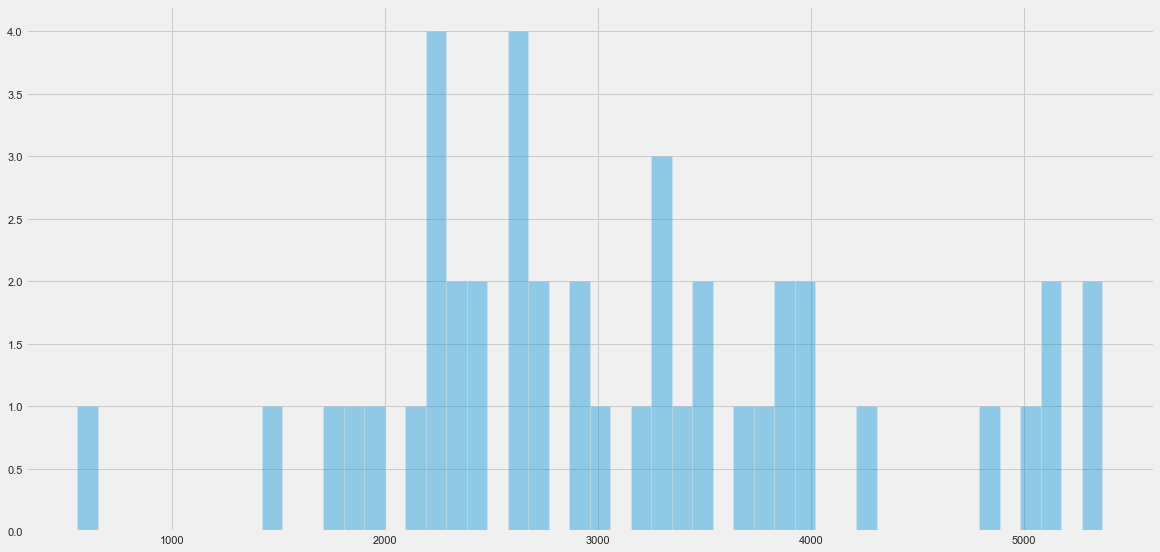

In [60]:
sns.distplot(list(presconf_script_keyword_df['word_count']), bins=50, kde=False)

In [61]:
# Drop text during the process to reduce the output size
presconf_script_chair_day_df.drop(columns=['text_sections', 'org_text'], inplace=True)
presconf_script_split_df.drop(columns=['text_sections', 'org_text'], inplace=True)
presconf_script_keyword_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Meeting Script DataFrame

In [62]:
# Sample
print(meeting_script_df['contents'][2])

CHAIRMAN GREENSPAN.  Will  someone move  approval  of  theminutes  of  the  March  27th  meeting?

[SECTION]

MS.  SEGER.  I'll move  them.

[SECTION]

MR. KELLEY.  Second.

[SECTION]

CHAIRMAN GREENSPAN.  Without  objection.  Mr.  Cross,  would  youbring us  up  to  date  on  Desk operations?

[SECTION]

MR.  CROSS.  [Statement--see  Appendix.]

[SECTION]

CHAIRMAN GREENSPAN.  Questions  for  Mr.  Cross?  If  there  areno  questions,  would  somebody like  to  move  the  ratification  of  histransactions  since  the  last  meeting?

[SECTION]

VICE  CHAIRMAN  CORRIGAN.  So  moved.

[SECTION]

SPEAKER(?).  Second.

[SECTION]

CHAIRMAN  GREENSPAN.  Without  objection.  Mr.  Sternlight.

[SECTION]

MR.  STERNLIGHT.  Thank you,  Mr.  Chairman.  [Statement--seeAppendix.]

[SECTION]

CHAIRMAN  GREENSPAN.  Are  there  any  questions  for Mr.Sternlight?

[SECTION]

MR.  HOSKINS.  Peter,  in  March  I asked  about  collateral  toback  the  Federal  Reserve  notes.  You thought  there might  be

In [63]:
# Reorganize the dataframe
proc_meeting_script_df = reorganize_df(meeting_script_df, 'meeting_script')


No rate decision found:  0
Shape of the dataframe:  (200, 13)


In [64]:
# Check the returned dataframe
proc_meeting_script_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,meeting_script,1990-02-07,FOMC Meeting Transcript,Alan Greenspan,27040,0,8.25,1990-03-27,0,8.25,MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.][SECTION]MESSRS. PRELL & TRUMAN. [Statements--see Appendix.][SECTION]CHAIRMAN GREENSPAN. Questions for the gentlemen?[SECTION]MR. ...,"[MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.], MESSRS. PRELL & TRUMAN. [Statements--see Appendix.], CHAIRMAN GREENSPAN. Questions for the gentlemen?, MR. JOHNSON. First to ...",MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentleme...
1,meeting_script,1990-03-27,FOMC Meeting Transcript,Alan Greenspan,39963,0,8.25,1990-04-11,0,8.25,CHAIRMAN GREENSPAN. Governor LaWare has moved that it is agood morning. Are there any seconds?[SECTION]MR. JOHNSON. Second.[SECTION]SPEAKER(?). It's too early to tell![SECTION]CH...,"[CHAIRMAN GREENSPAN. Governor LaWare has moved that it is agood morning. Are there any seconds?, MR. JOHNSON. Second., SPEAKER(?). It's too early to tell!, CHAIRMAN GREENSPAN. C...",CHAIRMAN GREENSPAN. Governor LaWare has moved that it is agood morning. Are there any seconds?\n\n[SECTION]\n\nMR. JOHNSON. Second.\n\n[SECTION]\n\nSPEAKER(?). It's too early to ...
2,meeting_script,1990-05-15,FOMC Meeting Transcript,Alan Greenspan,17304,0,8.25,1990-07-03,0,8.25,CHAIRMAN GREENSPAN. Will someone move approval of theminutes of the March 27th meeting?[SECTION]MS. SEGER. I'll move them.[SECTION]MR. KELLEY. Second.[SECTION]CHAIRMAN GREENSPAN. Wi...,"[CHAIRMAN GREENSPAN. Will someone move approval of theminutes of the March 27th meeting?, MS. SEGER. I'll move them., MR. KELLEY. Second., CHAIRMAN GREENSPAN. Without objection. M...",CHAIRMAN GREENSPAN. Will someone move approval of theminutes of the March 27th meeting?\n\n[SECTION]\n\nMS. SEGER. I'll move them.\n\n[SECTION]\n\nMR. KELLEY. Second.\n\n[SECTION]\n\...
3,meeting_script,1990-07-03,FOMC Meeting Transcript,Alan Greenspan,26864,0,8.25,1990-08-21,0,8.00,"CHAIRMAN GREENSPAN. Can we get started, please? If somebodywould like to move approval of the minutes--[SECTION]VICE CHAIRMAN CORRIGAN. So move.[SECTION]SPEAKER(?). Second.[SECTION...","[CHAIRMAN GREENSPAN. Can we get started, please? If somebodywould like to move approval of the minutes--, VICE CHAIRMAN CORRIGAN. So move., SPEAKER(?). Second., CHAIRMAN GREENSPAN....","CHAIRMAN GREENSPAN. Can we get started, please? If somebodywould like to move approval of the minutes--\n\n[SECTION]\n\nVICE CHAIRMAN CORRIGAN. So move.\n\n[SECTION]\n\nSPEAKER(?). ..."
4,meeting_script,1990-08-21,FOMC Meeting Transcript,Alan Greenspan,22419,0,8.00,1990-09-07,0,8.00,"CHAIRMAN GREENSPAN. Good morning, everyone. We'll startwith a controversial issue: approval of the minutes.[SECTION]SPEAKER(?). So move.[SECTION]CHAIRMAN GREENSPAN. Is there a se...","[CHAIRMAN GREENSPAN. Good morning, everyone. We'll startwith a controversial issue: approval of the minutes., SPEAKER(?). So move., CHAIRMAN GREENSPAN. Is there a second?, SPEAKE...","CHAIRMAN GREENSPAN. Good morning, everyone. We'll startwith a controversial issue: approval of the minutes.\n\n[SECTION]\n\nSPEAKER(?). So move.\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. ..."
5,meeting_script,1990-10-02,FOMC Meeting Transcript,Alan Greenspan,29203,0,8.00,1990-11-13,-1,7.50,"CHAIRMAN GREENSPAN. Good morning, everyone. Would somebodykindly move the minutes of the last FOMC meeting?[SECTION]MS. SEGER. I'll move.[SECTION]CHAIRMAN GREENSPAN. Is there a second...","[CHAIRMAN GREENSPAN. Good morning, everyone. Would somebodykindly move the minutes of the last FOMC meeting?, MS. SEGER. I'll move., CHAIRMAN GREENSPAN. Is there a second? Without o...","CHAIRMAN GREENSPAN. Good morning, everyone. Would somebodykindly move the minutes of the last FOMC meeting?\n\n[SECTION]\n\nMS. SEGER.

In [65]:
# Check which row does not have rate
proc_meeting_script_df.loc[proc_meeting_script_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text


(200, 13)


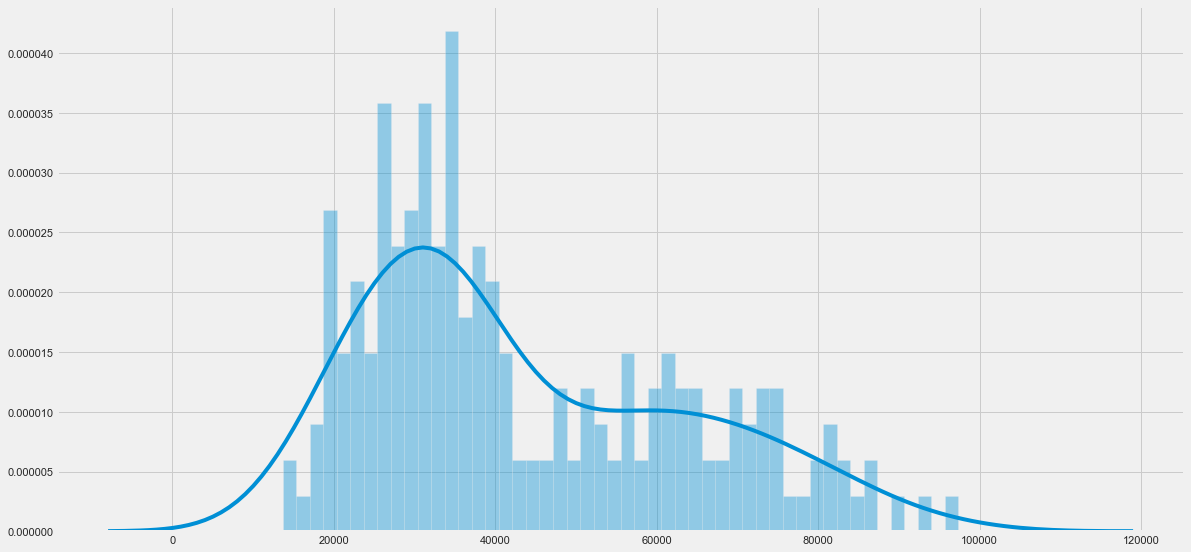

In [66]:
print(proc_meeting_script_df.shape)
sns.distplot(proc_meeting_script_df["word_count"].values, bins=50)

### Split by speakers
Scripts contain words from different people, so split by the speaker

In [67]:
script_data_list = []

for i, row in tqdm(proc_meeting_script_df.iterrows()):
    for text in row["text_sections"]:
        match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d? (.*)', text)
        if len(match) == 0:
            match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d(.*)', text)
            if len(match) == 0:
                print("not matched: ", text)
                print(row['date'])
                print()
        if len(match) == 1:
            speaker, text = match[0]
            row['speaker'] = speaker
            row['text'] = text
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            script_data_list.append(list(row))

col_name = proc_meeting_script_df.columns

meeting_script_speaker_df = pd.DataFrame(script_data_list, columns = col_name)
meeting_script_speaker_df

not matched:  MR.  [STERN(?)]  We  don't  have  a difference  in  interpretation.
1990-02-07 00:00:00

not matched:  MR. BERNARD.Chairman  Greenspan Vice  Chairman  Corrigan Governor Angell President Boehne President Boykin President Hoskins Governor  Johnson Governor Kelley Governor  LaWare Governor  Seger President  Stern YesYesYesYesYesYesYesYesYesNoYes
1990-02-07 00:00:00

not matched:  SPEAKER(?).  I'm  ready  for  lunch!
1990-02-07 00:00:00

not matched:  MR.  BERNARD.Chairman  Greenspan Vice  Chairman Corrigan YesYes2/6-7/90-41-Governor  Angell President  Boehne President  Boykin President Hoskins Governor  Johnson Governor Kelley Governor  LaWare Governor  Seger President  Stern NoYesYesYesYesYesYesNoYes
1990-02-07 00:00:00

not matched:  MR. BERNARD.Chairman  Greenspan Vice  Chairman  Corrigan Governor Angell President Boehne President Boykin President Hoskins Governor  Johnson Governor Kelley Governor  LaWare Governor  Seger President  Stern YesYesYesYesNoNoYesYesYesNoYes
19

not matched:  SPEAKER(?).  Sterilizing!
1991-02-06 00:00:00

not matched:  MR.  BERNARD.Chairman  GreenspanVice  Chairman  CorriganGovernor  AngellPresident  BlackPresident  ForrestalPresident  KeehnGovernor  KelleyGovernor  LaWareGovernor  MullinsPresident  ParryGovernor  SegerYesYesYesYesYesYesYesYesYesYesYes
1991-02-06 00:00:00

not matched:  SPEAKER(?).  Second.
1991-03-26 00:00:00

not matched:  SPEAKER(?).  Why didn't  you  sell  those bonds before  they  lostvalue?
1991-03-26 00:00:00

not matched:  SPEAKERS(?).  Good idea!3/26/91-19-
1991-03-26 00:00:00

not matched:  SPEAKER(?).  So  move.
1991-03-26 00:00:00

not matched:  SPEAKER(?).  Second.
1991-03-26 00:00:00

not matched:  SPEAKER(?).  The  thought  of  coffee  killed  any questions!
1991-03-26 00:00:00

not matched:  MR.  BERNARD.Chairman  Greenspan Vice  Chairman  Corrigan Governor  Angell President  Black President  Forrestal President Keehn Governor  Kelley Governor  LaWare Governor  Mullins President  Parry YesYesY

not matched:  MR.  BERNARD.Chairman Greenspan Vice  Chairman Corrigan Governor  Angell President  Hoenig President  Jordan Governor  Kelley Governor  LaWare Governor  Lindsey President  Melzer Governor  Mullins Governor  Phillips President  Syron YesYesYesYesNoYesYesYesYesYesNoYes
1992-07-01 00:00:00

not matched:  SPEAKER(?). I don't  like  that  "especially."
1992-07-01 00:00:00

not matched:  SPEAKER(?).  I don't  like  the  sentence  either.
1992-07-01 00:00:00

not matched:  SPEAKER(?).  Sounds  bad.
1992-07-01 00:00:00

not matched:  SPEAKER(?).  That's  the  problem.
1992-07-01 00:00:00

not matched:  MR.  BERNARD.Chairman  Greenspan Vice  Chairman  Corrigan Governor Angell President  Hoenig President  Jordan Governor  Kelley Governor  LaWare Governor  Lindsey President  Melzer Governor  Mullins Governor  Phillips President  Syron YesYesYesYesYesYesNoYesNoYesYesYes
1992-07-01 00:00:00

not matched:  SPEAKER(?).  Second.
1992-08-18 00:00:00

not matched:  MR.  BERNARD.
1992-08-18

not matched:  SPEAKER(?).  2:15.
1994-07-06 00:00:00

not matched:  SPEAKER(?).  That  is  what we have  been doing.
1994-07-06 00:00:00

not matched:  MR. BERNARD.Chairman Greenspan Vice Chairman McDonough Governor Blinder YesYesYes7/5-6/94-79-President Broaddus President Forrestal President Jordan Governor Kelley Governor LaWare Governor Lindsey President Parry Governor Phillips NoYesYesYesYesNo*YesYes
1994-07-06 00:00:00

not matched:  END OF MEETING*Secretary's note:  At  the  end  of  this meeting, Mr. Lindseyindicated  to  Chairman Greenspan  that his  dissent  on  the  operationalparagraph was based on  a possible misunderstanding of  the implicationsof  the bias  in  the  directive.  His  dissent was  from a directive  thathe  perceived as  calling  for a more or  less  automatic  tightening ofpolicy during  the  intermeeting period.  On  the understanding  that  anytightening during the  intermeeting period would depend on  furtherindications  of  inflationary developments,  

not matched:  MR. BERNARD.Chairman Greenspan Vice  Chairman McDonough Governor  Blinder President  Hoenig Governor Kelley Governor  Lindsey President  Melzer President Minehan President Moskow Governor  Phillips Governor Yellen YesYesYesYesYesYesYesYesYesYesYes
1995-05-23 00:00:00

not matched:  END OF  MEETING
1995-05-23 00:00:00

not matched:  SPEAKER(?).  It's  nonearning.
1995-07-06 00:00:00

not matched:  SPEAKER(?).  It's  an  outright purchase.
1995-07-06 00:00:00

not matched:  SPEAKER(?).  I so  move.
1995-07-06 00:00:00

not matched:  MR. PARRY.They are  out.7/5-6/95-22-
1995-07-06 00:00:00

not matched:  SPEAKER(?).  You have  a point.
1995-07-06 00:00:00

not matched:  SPEAKER(?).  It  used to  be M1.
1995-07-06 00:00:00

not matched:  MR. BERNARD.Chairman Greenspan Vice Chairman McDonough Governor  Blinder President  Hoenig Governor Kelley Governor Lindsey President Melzer President Minehan President Moskow Governor  Phillips Governor Yellen YesYesNoYesYesYesYesYesYesYesN

not matched:  MR. BERNARD.Chairman Greenspan Vice Chairman  McDonough Governor  Ferguson Governor  Gramlich President Hoenig President Jordan Governor Kelley President McTeer Governor Meyer President Minehan Governor Phillips Governor Rivlin YesYesYesYesYesYesYesYesYesYesYesYes2/3-4/98
1998-02-04 00:00:00

not matched:  MR.  BERNARD.Chairman  Greenspan Vice  Chairman McDonough Governor Ferguson Governor Gramlich President Hoenig President Jordan Governor  Kelley President McTeer Governor  Meyer President Minehan Governor Phillips Governor Rivlin YesYesYesYesYesYesYesYesYesYesYesYes
1998-02-04 00:00:00

not matched:  END OF MEETING
1998-02-04 00:00:00

not matched:  SPEAKER(?).  That's right.
1998-03-31 00:00:00

not matched:  MR.  BERNARD.Chairman  Greenspan Vice  Chairman  McDonough Governor Ferguson Governor GramlichYesYesYes
1998-03-31 00:00:00

not matched:  MR.  BERNARD.President  Hoenig President Jordan Governor  Kelley Governor  Meyer President Minehan Governor  Phillips Presid

not matched:  SPEAKER(?).  Second. 
2003-06-25 00:00:00

not matched:  END OF MEETING
2003-06-25 00:00:00

not matched:  SPEAKERS(?).  Second. 
2003-08-12 00:00:00

not matched:  SPEAKER(?).  Good answer. 
2003-08-12 00:00:00

not matched:  END OF MEETING
2003-08-12 00:00:00

not matched:  END OF MEETING
2003-09-15 00:00:00

not matched:  END OF MEETING
2003-09-16 00:00:00

not matched:  SPEAKER(?).  But we’re the 800-pound gorilla in the market. 
2003-10-28 00:00:00

not matched:  END OF MEETING
2003-10-28 00:00:00

not matched:  SPEAKER(?).  With speed limits. 
2003-12-09 00:00:00

not matched:  END OF MEETING
2003-12-09 00:00:00

not matched:  SPEAKER(?).  So moved. 
2004-01-28 00:00:00

not matched:  SPEAKER(?).  Now I’ll know in the future! [Coffee break] 
2004-01-28 00:00:00

not matched:  SPEAKER(?).  Yes, that’s a good idea.   let’s make that change in the statement. [Secretary’s note: The change in question was not in the paragraph of the statement covered by the foregoing vot

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,meeting_script,1990-02-07,FOMC Meeting Transcript,MESSRS. CROSS,4,0,8.25,1990-03-27,0,8.25,& STERNLIGHT. [Statements--see Appendix.],"[MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.], MESSRS. PRELL & TRUMAN. [Statements--see Appendix.], CHAIRMAN GREENSPAN. Questions for the gentlemen?, MR. JOHNSON. First to ...",MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentleme...
1,meeting_script,1990-02-07,FOMC Meeting Transcript,MESSRS. PRELL,4,0,8.25,1990-03-27,0,8.25,& TRUMAN. [Statements--see Appendix.],"[MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.], MESSRS. PRELL & TRUMAN. [Statements--see Appendix.], CHAIRMAN GREENSPAN. Questions for the gentlemen?, MR. JOHNSON. First to ...",MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentleme...
2,meeting_script,1990-02-07,FOMC Meeting Transcript,CHAIRMAN GREENSPAN,4,0,8.25,1990-03-27,0,8.25,Questions for the gentlemen?,"[MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.], MESSRS. PRELL & TRUMAN. [Statements--see Appendix.], CHAIRMAN GREENSPAN. Questions for the gentlemen?, MR. JOHNSON. First to ...",MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentleme...
3,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. JOHNSON,92,0,8.25,1990-03-27,0,8.25,"First to Mike: Given the fact that theinflation picture remains stable in spite of slower growth, I waslooking at the profits trend and it's down. There is quite a prof...","[MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.], MESSRS. PRELL & TRUMAN. [Statements--see Appendix.], CHAIRMAN GREENSPAN. Questions for the gentlemen?, MR. JOHNSON. First to ...",MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentleme...
4,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. PRELL,299,0,8.25,1990-03-27,0,8.25,"Well, there are a couple of pieces to that andthey are both areas in which researchers have argued a great deal andhave not reached definitive conclusions. One is the in...","[MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.], MESSRS. PRELL & TRUMAN. [Statements--see Appendix.], CHAIRMAN GREENSPAN. Questions for the gentlemen?, MR. JOHNSON. First to ...",MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentleme...
5,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. JOHNSON,288,0,8.25,1990-03-27,0,8.25,"Okay, thanks. A question for Ted on thedollar, and this is something I raised yesterday too [at the Boardbriefing]: I realize the dollar has depreciated from the peak in 198...","[MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.], MESSRS. PRELL & TRUMAN. [Statements--see Appendix.], CHAIRMAN GREENSPAN. Questions for the gentlemen?, MR. JOHNSON. First to ...",MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentleme...
6,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. TRUMAN,23,0,8.25,1990-03-27,0,8.25,"Well, several things. One point is thatinflation in Germany and Japan, of course, is lower than the averagethat is shown there, so that--","[MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.], MESSRS. PRELL & TRUMAN. [Statements--see Appendix.], CHAIRMAN GREENSPAN. Questions for the gentlemen?, MR. JOHNSON. First to

Some are not matching the defined patterns but those unmatched ones do not look importnant. Thus ignore them here.

In [68]:
# Filter by word count having 20 or more.
print("Before: ", meeting_script_speaker_df.shape)
meeting_script_speaker_df = meeting_script_speaker_df.loc[meeting_script_speaker_df['word_count'] >= 20]
print("After: ", meeting_script_speaker_df.shape)

Before:  (60529, 13)
After:  (30374, 13)


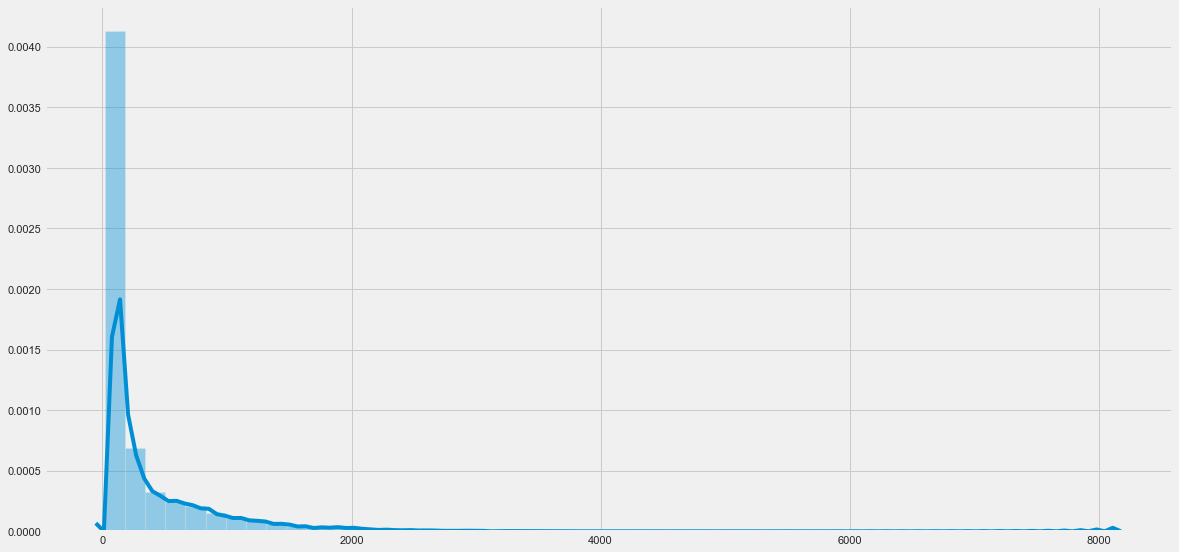

In [69]:
sns.distplot(meeting_script_speaker_df["word_count"].values, bins=50)

In [70]:
# Combine scripts for the same day.
meeting_script_speaker_df = meeting_script_speaker_df.groupby(['type', 'date', 'title', 'speaker', 'decision', 'rate', 'next_meeting', 'next_decision', 'next_rate'])['text'].apply('[SECTION]'.join).reset_index()
meeting_script_speaker_df['text_sections'] = meeting_script_speaker_df['text'].map(lambda x: x.split("[SECTION]"))
meeting_script_speaker_df['text'] = meeting_script_speaker_df['text'].map(lambda x: x.replace("[SECTION]", ""))
meeting_script_speaker_df['word_count'] = meeting_script_speaker_df['text'].map(get_word_count)
meeting_script_speaker_df


,type,date,title,speaker,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,word_count
0,meeting_script,1990-02-07,FOMC Meeting Transcript,CHAIRMAN GREENSPAN,0,8.25,1990-03-27,0,8.25,There's another thing that I suspect allof us have in the back of our minds and that is that somewhere in thistimeframe there is [likely to be] a recession. And the abil...,[ There's another thing that I suspect allof us have in the back of our minds and that is that somewhere in thistimeframe there is [likely to be] a recession. And the abi...,903
1,meeting_script,1990-02-07,FOMC Meeting Transcript,CHAIRMAN GREENSPAN,0,8.25,1990-03-27,0,8.25,"And to the extent that the process mightaccelerate, as indeed it has in the past, we might find that--youknow, it says 1990 to 1994--they might not be full years. They ...","[ And to the extent that the process mightaccelerate, as indeed it has in the past, we might find that--youknow, it says 1990 to 1994--they might not be full years. They ...",1220
2,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. ANGELL,0,8.25,1990-03-27,0,8.25,"You can move to amend, that's right. Mr.Chairman, the reason that I wanted to be earliest is because I reallyhave another suggestion. And if my suggestion gets a second, w...","[ You can move to amend, that's right. Mr.Chairman, the reason that I wanted to be earliest is because I reallyhave another suggestion. And if my suggestion gets a second, ...",163
3,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. ANGELL. My number for real GNP,0,8.25,1990-03-27,0,8.25,"is right underneath thestaff's at 1-1/2 percent real growth, but my nominal number isconsiderably less [than the staff's number]. I put nominal GNP justbarely above 4 percen...","[is right underneath thestaff's at 1-1/2 percent real growth, but my nominal number isconsiderably less [than the staff's number]. I put nominal GNP justbarely above 4 perce...",681
4,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. BERNARD,0,8.25,1990-03-27,0,8.25,"I'm reading from line 59 of the draft directiveor from page 24 in the Bluebook: ""The Federal Open Market Committeeseeks monetary and financial conditions that will foster p...","[ I'm reading from line 59 of the draft directiveor from page 24 in the Bluebook: ""The Federal Open Market Committeeseeks monetary and financial conditions that will foster ...",256
5,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. BLACK,0,8.25,1990-03-27,0,8.25,"Mr. Chairman, Governor Johnson's questioningabout these real long-term interest rates prompted me to look at thefootnotes on Chart 15 down in the lower left-hand corner wh...","[ Mr. Chairman, Governor Johnson's questioningabout these real long-term interest rates prompted me to look at thefootnotes on Chart 15 down in the lower left-hand corner w...",701
6,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. BOEHNE,0,8.25,1990-03-27,0,8.25,"My interpretation, Mr. Chairman, of what we didis that we took a straw vote and instead of doing it by raising handswe used our voices. And I view those two as largely equi...","[ My interpretation, Mr. Chairman, of what we didis that we took a straw vote and instead of doing it by raising handswe used our voices. And I view those two as largely equ...",61
7,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. BOYKIN,0,8.25,1990-03-27,0,8.25,"I remember several years ago I gave a verycomparable report and my good friend Ed Boehne leaned across the tableand said ""Boykin, that's a Texas problem."" So, maybe that's ju...","[ I remember several years ago I gave a verycomparable report and my good friend Ed Boehne leaned across the tableand said ""Boykin, that's a Texas problem."" So, maybe that's j...",289
8,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. CROSS,0,8.25,1990-03-27,0,8.25,"Well, I certainly agree with Ted. I think whatis happening in the market reflects the view that Gorbachev is incharge and things are likely to move ahead in a stable rather...","[ Well

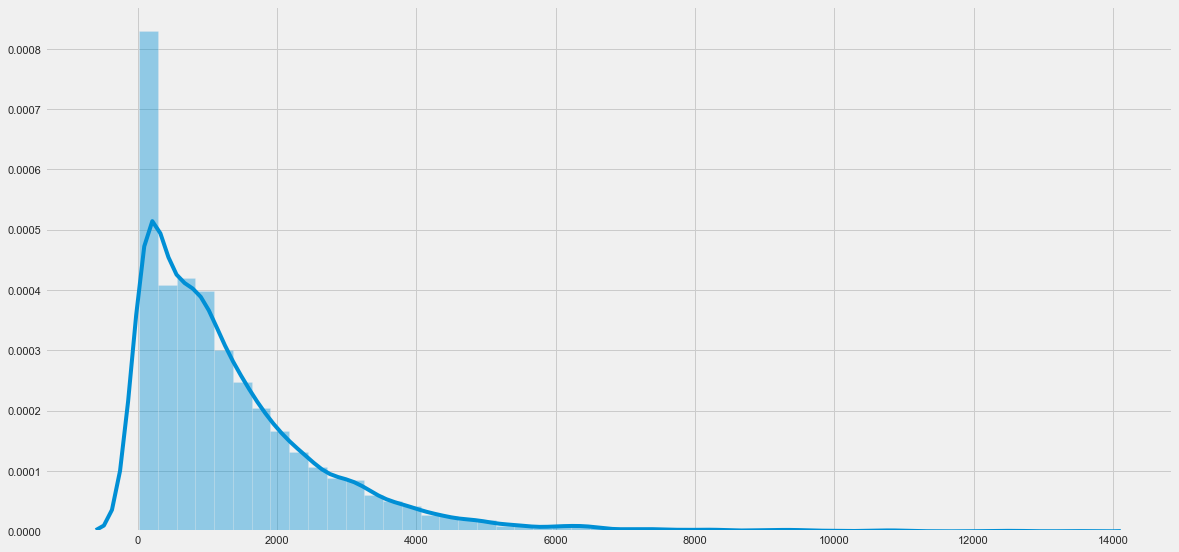

In [71]:
sns.distplot(meeting_script_speaker_df["word_count"].values, bins=50)

### Split contents to max 200 words

In [72]:
meeting_script_split_df = get_split_df(meeting_script_speaker_df)
print(meeting_script_split_df.shape)
meeting_script_split_df


(57098, 12)


,type,date,title,speaker,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,word_count
0,meeting_script,1990-02-07,FOMC Meeting Transcript,CHAIRMAN GREENSPAN,0,8.25,1990-03-27,0,8.25,There's another thing that I suspect allof us have in the back of our minds and that is that somewhere in thistimeframe there is likely to be a recession And the ability tolock onto an appropriate...,[ There's another thing that I suspect allof us have in the back of our minds and that is that somewhere in thistimeframe there is [likely to be] a recession. And the abi...,200
1,meeting_script,1990-02-07,FOMC Meeting Transcript,CHAIRMAN GREENSPAN,0,8.25,1990-03-27,0,8.25,up thediscussion to amendments on changes in both and debt So if theSecretary will read I beg your pardon I m sorry Are you okay Alternative II is moved and seconded We re now open to amendments o...,[ There's another thing that I suspect allof us have in the back of our minds and that is that somewhere in thistimeframe there is [likely to be] a recession. And the abi...,200
2,meeting_script,1990-02-07,FOMC Meeting Transcript,CHAIRMAN GREENSPAN,0,8.25,1990-03-27,0,8.25,of them and I So in effect there is no evidence atthis particular stage that were we to move in that direction we d haveto reverse and move it back up in Sometimes it is easier just to find outqui...,[ There's another thing that I suspect allof us have in the back of our minds and that is that somewhere in thistimeframe there is [likely to be] a recession. And the abi...,200
3,meeting_script,1990-02-07,FOMC Meeting Transcript,CHAIRMAN GREENSPAN,0,8.25,1990-03-27,0,8.25,the physical aspects of the economy more specifically theincome and product accounts analysis against the balance sheets ofthe financial system If you look strictly at the movement of income consu...,[ There's another thing that I suspect allof us have in the back of our minds and that is that somewhere in thistimeframe there is [likely to be] a recession. And the abi...,200
4,meeting_script,1990-02-07,FOMC Meeting Transcript,CHAIRMAN GREENSPAN,0,8.25,1990-03-27,0,8.25,of very modest acceleration going on Initial claims whichwill be published tomorrow come down under our seasonals from theirsharp peak of the week before although insured unemployment for theweek ...,[ There's another thing that I suspect allof us have in the back of our minds and that is that somewhere in thistimeframe there is [likely to be] a recession. And the abi...,200
5,meeting_script,1990-02-07,FOMC Meeting Transcript,CHAIRMAN GREENSPAN,0,8.25,1990-03-27,0,8.25,profit marginsincreasing at a relatively stable rate excluding the energy and foodexplosions what we are looking at is stable price inflation withfalling profit margins which implies that underlyi...,[ There's another thing that I suspect allof us have in the back of our minds and that is that somewhere in thistimeframe there is [likely to be] a recession. And the abi...,153
6,meeting_script,1990-02-07,FOMC Meeting Transcript,CHAIRMAN GREENSPAN,0,8.25,1990-03-27,0,8.25,And to the extent that the process mightaccelerate as indeed it has in the past we might find that youknow it says to they might not be full years They may month years and the thing can actually a...,"[ And to the extent that the process mightaccelerate, as indeed it has in the past, we might find that--youknow, it says 1990 to 1994--they might not be full years. They ...",200
7,meeting_script,1990-02-07,FOMC Meeting Transcript,CHAIRMAN GREENSPAN,0,8.25,1990-03-27,0,8.25,and the same is true ondebt But on the impression that I originally had which I think anumber of us had about the need to calibrate down I think this hasgiven us a somewhat different focus at this...,"[ And to the extent that the process mightaccelerate, as indeed it has in the past, we might find that--youknow, it says 1990 to 1994--they might not be full years. They ...",200
8,meeting_script,1990-02-07,FOMC Meeting Transcript,CHAIRMAN GREENSPAN,0,8.25,1990-03-27,0,8.25,of

### Filter out by keywords

In [73]:
# Keep sections having keywords and long enough
meeting_script_keyword_df = remove_short_nokeyword(meeting_script_speaker_df)
meeting_script_keyword_df.reset_index(drop=True, inplace=True)
print(meeting_script_keyword_df.shape)
meeting_script_keyword_df


(4131, 12)


,type,date,title,speaker,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,word_count
0,meeting_script,1990-02-07,FOMC Meeting Transcript,CHAIRMAN GREENSPAN,0,8.25,1990-03-27,0,8.25,It was one of the things that slippedthrough my in-box and that I read as it was going to my out-box. Thegeneral thrust of the piece--. As I recall it was not contempor...,[ It was one of the things that slippedthrough my in-box and that I read as it was going to my out-box. Thegeneral thrust of the piece--. As I recall it was not contemp...,555
1,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. ANGELL. My number for real GNP,0,8.25,1990-03-27,0,8.25,"is right underneath thestaff's at 1-1/2 percent real growth, but my nominal number isconsiderably less [than the staff's number]. I put nominal GNP justbarely above 4 percen...","[is right underneath thestaff's at 1-1/2 percent real growth, but my nominal number isconsiderably less [than the staff's number]. I put nominal GNP justbarely above 4 perce...",681
2,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. BLACK,0,8.25,1990-03-27,0,8.25,"Mr. Chairman, Governor Johnson's questioningabout these real long-term interest rates prompted me to look at thefootnotes on Chart 15 down in the lower left-hand corner whe...","[ Mr. Chairman, Governor Johnson's questioningabout these real long-term interest rates prompted me to look at thefootnotes on Chart 15 down in the lower left-hand corner w...",59
3,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. FORRESTAL,0,8.25,1990-03-27,0,8.25,"Mr. Chairman, if I may start with theDistrict, I would say that the Sixth District's economy is pretty muchthe same as that of the nation--as good or as bad, depending on ...","[ Mr. Chairman, if I may start with theDistrict, I would say that the Sixth District's economy is pretty muchthe same as that of the nation--as good or as bad, depending o...",680
4,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. GUFFEY,0,8.25,1990-03-27,0,8.25,"Thank you, Mr. Chairman. With regard to theforecast over the upcoming forecast period, for 1990 we're very closeto the Greenbook forecast--a tick stronger in real growth and ver...","[ Thank you, Mr. Chairman. With regard to theforecast over the upcoming forecast period, for 1990 we're very closeto the Greenbook forecast--a tick stronger in real growth and v...",481
5,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. HOSKINS,0,8.25,1990-03-27,0,8.25,I might also point out in terms of long-termstrategy that the only one that has 3 percent growth in 1994 for thereal economy happens to be the tighter policy. And isn't th...,[ I might also point out in terms of long-termstrategy that the only one that has 3 percent growth in 1994 for thereal economy happens to be the tighter policy. And isn't ...,246
6,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. PARRY,0,8.25,1990-03-27,0,8.25,"Mr. Chairman, turning first to the nationaleconomy: At current levels of interest rates we would expect real GNPat slightly less than 2 percent for this year. However, we ...","[ Mr. Chairman, turning first to the nationaleconomy: At current levels of interest rates we would expect real GNPat slightly less than 2 percent for this year. However, we...",415
7,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. PRELL,0,8.25,1990-03-27,0,8.25,"Well, as we factor all that, there are threethings that have happened on the financial front recently. The dollarhas come down and, for the last few months, the dollar ha...","[ Well, as we factor all that, there are threethings that have happened on the financial front recently. The dollarhas come down and, for the last few months, the dollar ...",216
8,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. STERN,0,8.25,1990-03-27,0,8.25,"Well, there's little new to report as far as theDistrict economy is concerned. We've had a modest and sustainableexpansion underway for a long time now. It seems to be cont...","[ Well, there's little ne

In [74]:
# Drop text during the process to reduce the output size
meeting_script_speaker_df.drop(columns=['text_sections'], inplace=True)
meeting_script_split_df.drop(columns=['text_sections'], inplace=True)
meeting_script_keyword_df.drop(columns=['text_sections'], inplace=True)

## Speech DataFrame

In [75]:
# Reorganize the dataframe
proc_speech_df = reorganize_df(speech_df, 'speech')

No rate decision found:  1461
Shape of the dataframe:  (1461, 13)


In [76]:
# Check the returned dataframe
# Note that rate and decision are not applicable because speech is not at FOMC meeting
proc_speech_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,speech,1996-06-13,Bank supervision in a world economy,Chairman Alan Greenspan,3211,NaN,None,1996-07-03,0,5.25,"Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996[SECTION][SECTION]I am honored to present...","[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
1,speech,1996-06-18,Developments in electronic money and banking,"Governor Edward W. Kelley, Jr.",2694,NaN,None,1996-07-03,0,5.25,"Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments '96 Conference, Dallas, TexasJune 18, 1996[SECTION][SECTION]It is a pleasure to be here th...","[Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments '96 Conference, Dallas, TexasJune 18, 1996, , It is a pleasure to be here this afternoon ...","Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt i..."
2,speech,1996-09-08,Monetary policy objectives and strategy,Governor Laurence H. Meyer,2902,NaN,None,1996-09-24,0,5.25,Monetary Policy Objectives and Strategy[SECTION]I want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want ...,"[Monetary Policy Objectives and Strategy, I want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want to emp...",Monetary Policy Objectives and Strategy\n\n[SECTION]\n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I al...
3,speech,1996-09-19,Regulation and electronic payment systems,Chairman Alan Greenspan,1988,NaN,None,1996-09-24,0,5.25,"Remarks by Chairman Alan GreenspanRegulation of electronic payment systemsAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC September 19, 1996[SE...","[Remarks by Chairman Alan GreenspanRegulation of electronic payment systemsAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC September 19, 1996, ...","Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1..."
4,speech,1996-10-02,Small business is big business,Governor Lawrence B. Lindsey,2180,NaN,None,1996-11-13,0,5.25,"Remarks by Governor Lawrence B. LindseyAt the Small Business Development Conference, Richmond, VirginiaOctober 2, 1996[SECTION][SECTION]Small Business Is Big Business[SECTION]It is my pleasure to ...","[Remarks by Governor Lawrence B. LindseyAt the Small Business Development Conference, Richmond, VirginiaOctober 2, 1996, , Small Business Is Big Business, It is my pleasure to be here today at the...","Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nSmall Business Is Big Business\n\n[S..."
5,speech,1996-10-05,"Bank supervision, regulation, and risk",Chairman Alan Greenspan,2401,NaN,None,1996-11-13,0,5.25,"Remarks by Chairman Alan GreenspanBank supervision, regulation, and riskAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii Oc

(1461, 13)


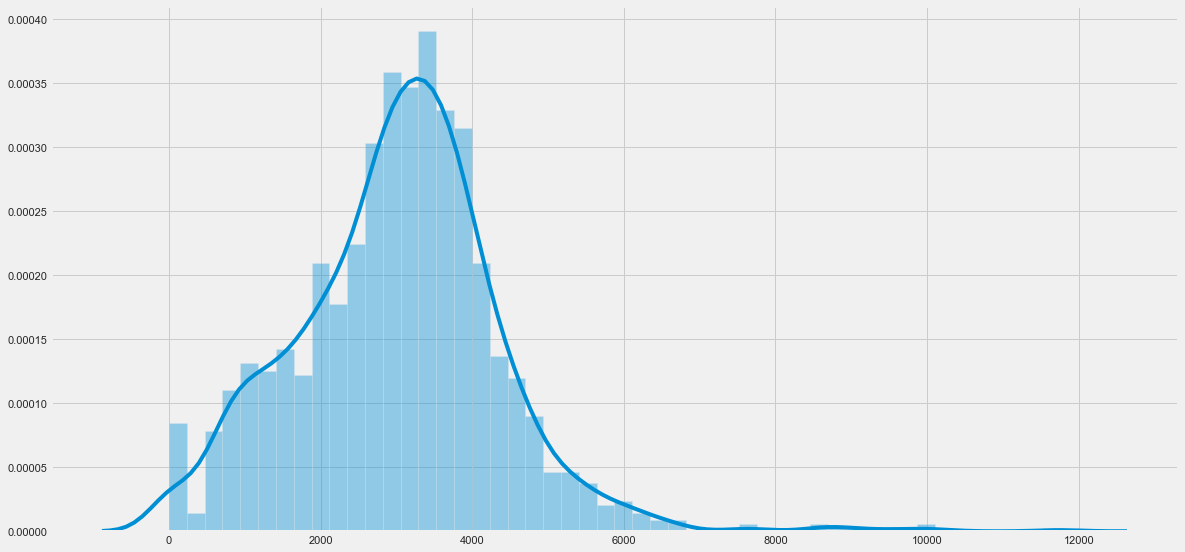

In [77]:
print(proc_speech_df.shape)
sns.distplot(proc_speech_df["word_count"].values, bins=50)

In [78]:
# Check records where speaker is null
proc_speech_df['speaker'].isnull().sum()

0

In [79]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
proc_speech_df = remove_short_section(proc_speech_df, min_words=50)
proc_speech_df


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,speech,1996-06-13,Bank supervision in a world economy,Chairman Alan Greenspan,3095,NaN,None,1996-07-03,0,5.25,I am honored to present the William Taylor Memorial Lecture to such a distinguished group of senior bank supervisors from around the world. I am especially delighted to have with us B...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
1,speech,1996-06-18,Developments in electronic money and banking,"Governor Edward W. Kelley, Jr.",2659,NaN,None,1996-07-03,0,5.25,"It is a pleasure to be here this afternoon to provide the Federal Reserve's perspective on recent developments in the field of electronic money and banking. To begin, let me remind yo...","[Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments '96 Conference, Dallas, TexasJune 18, 1996, , It is a pleasure to be here this afternoon ...","Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt i..."
2,speech,1996-09-08,Monetary policy objectives and strategy,Governor Laurence H. Meyer,2729,NaN,None,1996-09-24,0,5.25,I want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want to emphasize the importance of setting monetary ...,"[Monetary Policy Objectives and Strategy, I want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want to emp...",Monetary Policy Objectives and Strategy\n\n[SECTION]\n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I al...
3,speech,1996-09-19,Regulation and electronic payment systems,Chairman Alan Greenspan,1586,NaN,None,1996-09-24,0,5.25,You have heard many points of view today on electronic moneyand banking. New products are being designed to challenge theuse of currency and checks in millions of routine consumertransactions. O...,"[Remarks by Chairman Alan GreenspanRegulation of electronic payment systemsAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC September 19, 1996, ...","Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1..."
4,speech,1996-10-02,Small business is big business,Governor Lawrence B. Lindsey,2002,NaN,None,1996-11-13,0,5.25,"A fair question might be, what is the nation's central bank doing sponsoring aconference on small business? Well, let me be clear about one thing, neither I nor mycolleagues from the Fed are goi...","[Remarks by Governor Lawrence B. LindseyAt the Small Business Development Conference, Richmond, VirginiaOctober 2, 1996, , Small Business Is Big Business, It is my pleasure to be here today at the...","Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nSmall Business Is Big Business\n\n[S..."
5,speech,1996-10-05,"Bank supervision, regulation, and risk",Chairman Alan Greenspan,2183,NaN,None,1996-11-13,0,5.25,You may well wonder why a regulator is the first speaker at a conference in which amajor theme is maximizing shareholder value. I hope that by the end of my remarks thismorning it will be 

In [80]:
# Extract Chairperson's speech
tmp_list = []
for i, row in proc_speech_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson.lower().split()[-1] in row['speaker'].lower():
        row['speaker'] = chairperson
        tmp_list.append(list(row))

col_names = proc_speech_df.columns
speech_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)

print(speech_chair_df.shape)
speech_chair_df

(427, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,3095,NaN,None,1996-07-03,0.0,5.25,I am honored to present the William Taylor Memorial Lecture to such a distinguished group of senior bank supervisors from around the world. I am especially delighted to have with us B...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
1,speech,1996-09-19,Regulation and electronic payment systems,Alan Greenspan,1586,NaN,None,1996-09-24,0.0,5.25,You have heard many points of view today on electronic moneyand banking. New products are being designed to challenge theuse of currency and checks in millions of routine consumertransactions. O...,"[Remarks by Chairman Alan GreenspanRegulation of electronic payment systemsAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC September 19, 1996, ...","Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1..."
2,speech,1996-10-05,"Bank supervision, regulation, and risk",Alan Greenspan,2183,NaN,None,1996-11-13,0.0,5.25,You may well wonder why a regulator is the first speaker at a conference in which amajor theme is maximizing shareholder value. I hope that by the end of my remarks thismorning it will be clear t...,"[Remarks by Chairman Alan GreenspanBank supervision, regulation, and riskAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii October 5, 1996, , You may well wonder why a...","Remarks by Chairman Alan Greenspan\nBank supervision, regulation, and risk\r\nAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii \r\nOctober 5, 1996\n\n[SECTION]\n\n\n\..."
3,speech,1996-10-07,U.S. Treasury securities market: Lessons from Alexander Hamilton,Alan Greenspan,985,NaN,None,1996-11-13,0.0,5.25,I thank the members of the Public Securities Association for bestowing upon me this award for distinguished public service. I am particularly honored by the company that I keep as a winner of thi...,"[Remarks by Chairman Alan GreenspanU.S. Treasury securities market: Lessons from Alexander HamiltonAt the Annual Public Service Awards Dinner of the Public Securities Association, New York, New Yo...","Remarks by Chairman Alan Greenspan\nU.S. Treasury securities market: Lessons from Alexander Hamilton\r\nAt the Annual Public Service Awards Dinner of the Public Securities Association, New York, N..."
4,speech,1996-10-16,Technological advances and productivity,Alan Greenspan,1615,NaN,None,1996-11-13,0.0,5.25,The Conference Board has been an important institution in my life. It was where I started as an economist. It was where I came into contact with a business world I had never known before. The y...,"[Remarks by Chairman Alan GreenspanTechnological advances and productivityAt the 80th Anniversary Awards Dinner of The Conference Board, New York, New YorkOctober 16, 1996, , It is a pleasure to b...","Remarks by Chairman Alan Greenspan\nTechnological advances and productivity\r\nAt the 80th Anniversary Awards Dinner of The Conference Board, New York, New York\r\nOctober 16, 1996\n\n[SECTION]\n\..."
5,speech,1996-11-18,Banking in the global marketplace,Alan Greenspan,5822,NaN,None,1996-12-17,0.0,5.25,It is again a pleasure to be here in Tokyo at the invitation of the Bank of Japan. Tokyo's role as one of the world's key financial centers depends importantly on the confidence of the internation...,"[, Banking in

### Split contents to max 200 words

In [81]:
speech_split_df = get_split_df(speech_chair_df)
speech_split_df.reset_index(drop=True, inplace=True)
print(speech_split_df.shape)
speech_split_df


(7047, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,NaN,None,1996-07-03,0,5.25,I am honored to present the William Taylor Memorial Lecture to such a distinguished group of senior bank supervisors from around the world I am especially delighted to have with us Bill's wife Sha...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
1,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,NaN,None,1996-07-03,0,5.25,best from himself and from those around him He understood that a safe and sound banking system was essential to a healthy market system and he was committed to maintaining such a system His contri...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
2,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,NaN,None,1996-07-03,0,5.25,reflect the increased efficiency of financial markets worldwide which have helped to bring about expanded international trade and economic growth However by strengthening the interdependencies amo...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
3,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,NaN,None,1996-07-03,0,5.25,relationship we may have a better framework for considering how to supervise and regulate our financial institutions A Leveraged Banking System In addressing these issues it is important to rememb...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
4,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,NaN,None,1996-07-03,0,5.25,of intermediation with the founding of the Riksbank more than years ago as a private institution Of course this same leverage and risk taking also greatly increases the possibility of bank failure...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
5,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,NaN,None,1996-07-03,0,5.25,other financial intermediaries play in our financial systems such failures could have large ripple effects that spread throughout business and financial markets at great costs The Distribution of ...,"[Remarks by Chairman Alan GreenspanBank supervision 

### Filter out by keyword

In [82]:
# Keep sections having keywords and long enough
speech_keyword_df = remove_short_nokeyword(speech_chair_df)
speech_keyword_df.reset_index(drop=True, inplace=True)
print(speech_keyword_df.shape)
speech_keyword_df


(219, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,speech,1996-10-05,"Bank supervision, regulation, and risk",Alan Greenspan,136,NaN,None,1996-11-13,0.0,5.25,"While awaiting perfection, it is useful to underline that regulators and banks have acommon interest in using the evolving new technologies to meet their own separateobjectives: maximizing shareh...","[While awaiting perfection, it is useful to underline that regulators and banks have acommon interest in using the evolving new technologies to meet their own separateobjectives: maximizing share...","Remarks by Chairman Alan Greenspan\nBank supervision, regulation, and risk\r\nAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii \r\nOctober 5, 1996\n\n[SECTION]\n\n\n\..."
1,speech,1996-12-06,Social security,Alan Greenspan,253,NaN,None,1996-12-17,0.0,5.25,"While such evaluations are based on an uncertain future, the benefit per current retiree under existing law, adjusted for inflation, can be forecast with some precision over the next thirty years....","[While such evaluations are based on an uncertain future, the benefit per current retiree under existing law, adjusted for inflation, can be forecast with some precision over the next thirty years...","\n\n[SECTION]\n\nI am privileged to accept the Union League of Philadelphia's Abraham Lincoln award. This is the first time I have been at the Union League in nearly four decades, but I am gratif..."
2,speech,1997-01-14,Central banking and global finance,Alan Greenspan,133,NaN,None,1997-02-05,0.0,5.25,"In theory, the allocation of responsibility for risk-bearing between the private sectorand the central bank depends upon an evaluation of the private cost of capital. In order toattract, or at le...","[In theory, the allocation of responsibility for risk-bearing between the private sectorand the central bank depends upon an evaluation of the private cost of capital. In order toattract, or at l...","\n\n[SECTION]\n\nCentral Banking and Global Finance\n\n[SECTION]\n\nMr. Prime Minister, Minister of Finance, Minister of Budget, Rector Oosterlinck,\r\nProfessor Peeters, ladies and gentlemen, it ..."
3,speech,1997-02-21,Government regulation and derivative contracts,Alan Greenspan,212,NaN,None,1997-03-25,1.0,5.50,"In the case of the institutional off-exchange derivatives markets, it seems abundantly clear that private market regulation is quite effectively and efficiently achieving what have been identified...","[In the case of the institutional off-exchange derivatives markets, it seems abundantly clear that private market regulation is quite effectively and efficiently achieving what have been identifie...","I am pleased to participate once again in the Federal Reserve Bank of Atlanta's annual Financial Markets Conference. As in previous years, the Reserve Bank has developed a conference program that..."
4,speech,1997-04-29,G-7 economic summit meeting,Alan Greenspan,142,NaN,None,1997-05-20,0.0,5.50,"In theory, the allocation of responsibility for risk-bearing between the private sector and the central bank depends upon an evaluation of the private cost of capital. In order to attract, or at ...","[In theory, the allocation of responsibility for risk-bearing between the private sector and the central bank depends upon an evaluation of the private cost of capital. In order to attract, or at...","\n\n[SECTION]\n\nIt is a pleasure to be here today.\n\n[SECTION]\n\nI will take this occasion to offer some thoughts related to the upcoming G-7 economic summit meeting, which will be held in Denv..."
5,speech,1997-05-08,Current monetary policy,Alan Greenspan,144,NaN,None,1997-05-20,0.0,5.50,I viewed our small increase in the federal funds rate on March 25 as taken not so much as a consequence of a change in the most probable forecast of moderate growth and low inflation for later thi...,[I viewed our small increase in the federal funds rate on March 

In [83]:
# Drop text_sections
speech_chair_df.drop(columns=['text_sections', 'org_text'], inplace=True)
speech_split_df.drop(columns=['text_sections', 'org_text'], inplace=True)
speech_keyword_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Testimony DataFrame

In [84]:
# Reorganize the dataframe
# Note that rate and decision are not applicable because testimony is not at FOMC meeting
proc_testimony_df = reorganize_df(testimony_df, 'testimony')

No rate decision found:  436
Shape of the dataframe:  (436, 13)


In [85]:
# Check the returned dataframe
proc_testimony_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,testimony,1996-06-26,Supervision of bank sales practices,"Governor Edward W. Kelley, Jr.",2298,NaN,None,1996-07-03,0,5.25,[SECTION][SECTION][SECTION][SECTION]It is a pleasure to appear before this Subcommittee to discuss the supervision of bank sales practices on behalf of the Federal Reserve. The recent pub...,"[, , , , It is a pleasure to appear before this Subcommittee to discuss the supervision of bank sales practices on behalf of the Federal Reserve. The recent publication of various survey ...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt is a pleasure to appear before this Subcommittee to discuss\r\n\r\n the supervision of bank sales practices on behalf of ...
1,testimony,1996-07-17,"""Prime bank"" schemes","Herbert A. Biern, Deputy Associate Director, Division of Banking Supervision and Regulation",1227,NaN,None,1996-08-20,0,5.25,"[SECTION][SECTION][SECTION][SECTION]I am pleased to appear before the Committee on Banking, Housing, and Urban Affairs to discuss actions that the Federal Reserve has taken over the past s...","[, , , , I am pleased to appear before the Committee on Banking, Housing, and Urban Affairs to discuss actions that the Federal Reserve has taken over the past several years to address the...","\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before the Committee on Banking, Housing,\r\n\r\n and Urban Affairs to discuss actions that the Feder..."
2,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Chairman Alan Greenspan,3372,NaN,None,1996-08-20,0,5.25,"Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996[SECTION]Before I t...","[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
3,testimony,1996-07-24,Trends in consumer lending,Governor Janet L. Yellen,2878,NaN,None,1996-08-20,0,5.25,[SECTION][SECTION][SECTION][SECTION]I am pleased to appear before this Subcommittee today to discuss trendsin consumer lending and the Federal Reserve Board's view of how recentdevelopments in thi...,"[, , , , I am pleased to appear before this Subcommittee today to discuss trendsin consumer lending and the Federal Reserve Board's view of how recentdevelopments in this sector are affecting U.S....",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before this Subcommittee today to discuss trends\r\n\r\nin consumer lending and the Federal Reserve Board...
4,testimony,1996-07-26,Recent reports on Federal Reserve operations,Chairman Alan Greenspan,3764,NaN,None,1996-08-20,0,5.25,[SECTION][SECTION][SECTION][SECTION]I appreciate this opportunity to appear before the Banking Committeetoday to address certain recent reports on the Federal Reserve´s operations. Of mostrelevan...,"[, , , , I appreciate this opportunity to appear before the Banking Committeetoday to address certain recent reports on the Federal Reserve´s operations. Of mostrelevance, the GAO has raised some...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI appreciate this opportunity to appear before the Banking Committee\r\n\r\ntoday to address certain recent reports on the Feder...
5,testimony,1996-09-12,Trends in consumer lending,Governor Lawrence B. Lindsey,4712,NaN,None,1996-09-24,0,5.25,"[SECTION][SECTION][SECTION][SECTION]I am pleased to appear before this Committee today to discuss trends in consumerlending, the Federal Reser

(436, 13)


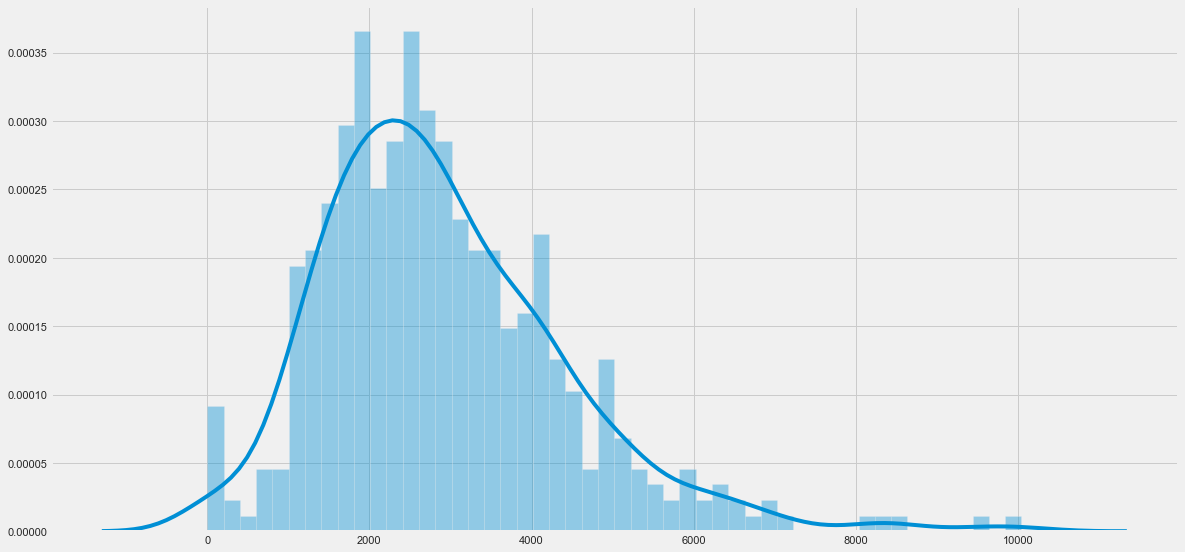

In [86]:
print(proc_testimony_df.shape)
sns.distplot(proc_testimony_df["word_count"].values, bins=50)

In [87]:
# Check records where speaker is null
proc_testimony_df['speaker'].isnull().sum()

0

In [88]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
proc_testimony_df = remove_short_section(proc_testimony_df, min_words=50)
proc_testimony_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,testimony,1996-06-26,Supervision of bank sales practices,"Governor Edward W. Kelley, Jr.",2071,NaN,None,1996-07-03,0,5.25,It is a pleasure to appear before this Subcommittee to discuss the supervision of bank sales practices on behalf of the Federal Reserve. The recent publication of various survey results h...,"[, , , , It is a pleasure to appear before this Subcommittee to discuss the supervision of bank sales practices on behalf of the Federal Reserve. The recent publication of various survey ...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt is a pleasure to appear before this Subcommittee to discuss\r\n\r\n the supervision of bank sales practices on behalf of ...
1,testimony,1996-07-17,"""Prime bank"" schemes","Herbert A. Biern, Deputy Associate Director, Division of Banking Supervision and Regulation",959,NaN,None,1996-08-20,0,5.25,"I am pleased to appear before the Committee on Banking, Housing, and Urban Affairs to discuss actions that the Federal Reserve has taken over the past several years to address the problem ...","[, , , , I am pleased to appear before the Committee on Banking, Housing, and Urban Affairs to discuss actions that the Federal Reserve has taken over the past several years to address the...","\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before the Committee on Banking, Housing,\r\n\r\n and Urban Affairs to discuss actions that the Feder..."
2,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Chairman Alan Greenspan,2966,NaN,None,1996-08-20,0,5.25,"Before I take this opportunity to discuss the performance of the U.S.economy and the conduct of monetary policy, I would first like to thank theChairman and the other members of this Committee for...","[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
3,testimony,1996-07-24,Trends in consumer lending,Governor Janet L. Yellen,2601,NaN,None,1996-08-20,0,5.25,I am pleased to appear before this Subcommittee today to discuss trendsin consumer lending and the Federal Reserve Board's view of how recentdevelopments in this sector are affecting U.S. commerci...,"[, , , , I am pleased to appear before this Subcommittee today to discuss trendsin consumer lending and the Federal Reserve Board's view of how recentdevelopments in this sector are affecting U.S....",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before this Subcommittee today to discuss trends\r\n\r\nin consumer lending and the Federal Reserve Board...
4,testimony,1996-07-26,Recent reports on Federal Reserve operations,Chairman Alan Greenspan,3308,NaN,None,1996-08-20,0,5.25,"We are strongly committed to ensuring that the Federal Reserve Systemis managed efficiently and effectively. It is most important to us at the FederalReserve Board and the Reserve Banks, not only...","[, , , , I appreciate this opportunity to appear before the Banking Committeetoday to address certain recent reports on the Federal Reserve´s operations. Of mostrelevance, the GAO has raised some...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI appreciate this opportunity to appear before the Banking Committee\r\n\r\ntoday to address certain recent reports on the Feder...
5,testimony,1996-09-12,Trends in consumer lending,Governor Lawrence B. Lindsey,4180,NaN,None,1996-09-24,0,5.25,"As Chairman Leach noted in his letter of invitation, consumer delinquencies onnonmortgage debt have increased in recent periods and bankruptc

In [89]:
# Extract Chairperson's speech
tmp_list = []
for i, row in proc_testimony_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson.lower().split()[-1] in row['speaker'].lower():
        row['speaker'] = chairperson
        tmp_list.append(list(row))

col_names = proc_testimony_df.columns
testimony_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)
testimony_chair_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,2966,NaN,None,1996-08-20,0.0,5.25,"Before I take this opportunity to discuss the performance of the U.S.economy and the conduct of monetary policy, I would first like to thank theChairman and the other members of this Committee for...","[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
1,testimony,1996-07-26,Recent reports on Federal Reserve operations,Alan Greenspan,3308,NaN,None,1996-08-20,0.0,5.25,"We are strongly committed to ensuring that the Federal Reserve Systemis managed efficiently and effectively. It is most important to us at the FederalReserve Board and the Reserve Banks, not only...","[, , , , I appreciate this opportunity to appear before the Banking Committeetoday to address certain recent reports on the Federal Reserve´s operations. Of mostrelevance, the GAO has raised some...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI appreciate this opportunity to appear before the Banking Committee\r\n\r\ntoday to address certain recent reports on the Feder...
2,testimony,1997-01-21,"January 21, 1997",Alan Greenspan,2854,NaN,None,1997-02-05,0.0,5.25,"Mr. Chairman and members of the Committee, I am pleased to appear here today. In just a few weeks the Federal Reserve Board will submit its semiannual report on monetary policy to the Congress. ...","[Testimony of Chairman Alan GreenspanPerformance of the U.S. economyBefore the Committee on the Budget, United States SenateJanuary 21, 1997, Mr. Chairman and members of the Committee, I am please...","Testimony of Chairman Alan Greenspan\nPerformance of the U.S. economy\r\nBefore the Committee on the Budget, United States Senate\r\nJanuary 21, 1997\n\n[SECTION]\n\nMr. Chairman and members of th..."
3,testimony,1997-01-30,The comsumer price index,Alan Greenspan,2692,NaN,None,1997-02-05,0.0,5.25,"Mr. Chairman and members of the Committee, I appreciate the opportunity to appear before you today. The Committee is faced with a number of complex policy issues that will have an important beari...","[Testimony of Chairman Alan GreenspanThe consumer price indexBefore the Committee on Finance, United States SenateJanuary 30, 1997, Mr. Chairman and members of the Committee, I appreciate the oppo...","Testimony of Chairman Alan Greenspan\nThe consumer price index\r\nBefore the Committee on Finance, United States Senate\r\nJanuary 30, 1997\n\n[SECTION]\n\nMr. Chairman and members of the Committe..."
4,testimony,1997-02-13,Modernization of the financial system,Alan Greenspan,4100,NaN,None,1997-03-25,1.0,5.50,"Madam Chairwoman, members of the Subcommittee on Financial Institutions and Consumer Credit, it is a pleasure to appear here today to present the views of the Federal Reserve Board on some broad i...","[Testimony of Chairman Alan GreenspanModernization of the financial systemBefore the Subcommittee on Financial Institutions and Consumer Credit\tof the Committee on Banking and Financial Services,...",Testimony of Chairman Alan Greenspan\nModernization of the financial system\r\nBefore the Subcommittee on Financial Institutions and Consumer Credit\r\n\tof the Committee on Banking and Financial ...
5,testimony,1997-02-26,The Federal Reserve's semiannual monetary policy report,Alan Greenspan,4159,NaN,None,1997-03-25,1.0,5.50,"The performance of the U.S. economy over the past year has been quite favorable. Real GDP growth picked up to more than three percent over the four quarters of 1996, as the economy progr...","[Testim

### Split contents to max 200 words

In [90]:
testimony_split_df = get_split_df(testimony_chair_df)
testimony_split_df.reset_index(drop=True, inplace=True)
print(testimony_split_df.shape)
testimony_split_df


(2789, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,200,NaN,None,1996-08-20,0,5.25,Before I take this opportunity to discuss the performance of the U S economy and the conduct of monetary policy I would first like to thank theChairman and the other members of this Committee for ...,"[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
1,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,200,NaN,None,1996-08-20,0,5.25,above their postwar averages About million workers have beenadded to nonfarm payrolls in the first six months of the year and theunemployment rate fell to percent in June Even though the U S econo...,"[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
2,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,200,NaN,None,1996-08-20,0,5.25,be better than manyanalysts expected An important supporting factor as I pointed out in February wasfavorable conditions in financial markets in the latter part of and early Intermediate and longe...,"[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
3,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,200,NaN,None,1996-08-20,0,5.25,better than those of many ofour major trading partners The rise in the dollar helps to keep down pricepressures but it also tends to divert domestic demand toward imported goods anddamp exports so...,"[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
4,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,200,NaN,None,1996-08-20,0,5.25,less rapidly asfinal demand slows some While these are all good reasons to anticipate that economic growth willmoderate some the timing and extent of that downshift are uncertain We havenot as yet...,"[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
5,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,200,NaN,None,1996-08-20,0,5.25,companies to the need for higher safety stocks Indeed indications ofsome mounting delivery delays in June do raise warning flags in this regard Thereversal o

### Filter out by keyword

In [91]:
# Keep sections having keywords and long enough
testimony_keyword_df = remove_short_nokeyword(testimony_chair_df)
testimony_keyword_df.reset_index(drop=True, inplace=True)
print(testimony_keyword_df.shape)
testimony_keyword_df


(122, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,628,NaN,None,1996-08-20,0.0,5.25,"Even though the U.S. economy is using its productive resources intensively,inflation has remained quiescent. The core inflation rate, measured by the consumerprice index less food and energy pric...","[Even though the U.S. economy is using its productive resources intensively,inflation has remained quiescent. The core inflation rate, measured by the consumerprice index less food and energy pri...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
1,testimony,1997-01-21,"January 21, 1997",Alan Greenspan,549,NaN,None,1997-02-05,0.0,5.25,"Mr. Chairman and members of the Committee, I am pleased to appear here today. In just a few weeks the Federal Reserve Board will submit its semiannual report on monetary policy to the Congress. ...","[Mr. Chairman and members of the Committee, I am pleased to appear here today. In just a few weeks the Federal Reserve Board will submit its semiannual report on monetary policy to the Congress. ...","Testimony of Chairman Alan Greenspan\nPerformance of the U.S. economy\r\nBefore the Committee on the Budget, United States Senate\r\nJanuary 21, 1997\n\n[SECTION]\n\nMr. Chairman and members of th..."
2,testimony,1997-02-26,The Federal Reserve's semiannual monetary policy report,Alan Greenspan,286,NaN,None,1997-03-25,1.0,5.50,"The performance of the U.S. economy over the past year has been quite favorable. Real GDP growth picked up to more than three percent over the four quarters of 1996, as the economy progr...","[The performance of the U.S. economy over the past year has been quite favorable. Real GDP growth picked up to more than three percent over the four quarters of 1996, as the economy prog...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nFebruary 26, 1997\n\n[..."
3,testimony,1997-03-20,Performance of the U.S. economy,Alan Greenspan,160,NaN,None,1997-03-25,1.0,5.50,"Indeed, the labor markets bear especially careful watching for signs that such a process is under way. So far this year, the demand for labor has stayed strong. Payroll employment grew briskly i...","[Indeed, the labor markets bear especially careful watching for signs that such a process is under way. So far this year, the demand for labor has stayed strong. Payroll employment grew briskly ...","Testimony of Chairman Alan Greenspan\nPerformance of the U.S. economy\r\nJoint Economic Committee, United States Congress\r\n\r\nMarch 20, 1997\n\n[SECTION]\n\n\n\n[SECTION]\n\nMr. Chairman and me..."
4,testimony,1997-07-22,The Federal Reserve's semiannual monetary policy report,Alan Greenspan,1068,NaN,None,1997-08-19,0.0,5.50,This strong expansion has produced a remarkable increase in work opportunities for Americans. A net of more than thirteen million jobs has been created since the ...,[This strong expansion has produced a remarkable increase in work opportunities for Americans. A net of more than thirteen million jobs has been created since the ...,"Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 22, 1997\n\n[SECT..."
5,testimony,1997-10-08,Economic and budgetary outlook,Alan Greenspan,139,NaN,None,1997-11-12,0.0,5.50,"The long-term outlook for the American economy presents us with, perhaps, even greater uncertainties. There can be little doubt that the American economy in the last several years has performed f...","[The long-term outlook for the American economy presents us with, perhaps, even gre

In [92]:
# Drop text sections
testimony_chair_df.drop(columns=['text_sections', 'org_text'], inplace=True)
testimony_split_df.drop(columns=['text_sections', 'org_text'], inplace=True)
testimony_keyword_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Save the train data

In [93]:
# Combine dataframes
text_no_split = pd.concat([proc_statement_df, 
                           proc_minutes_df, 
                           presconf_script_chair_day_df, 
                           meeting_script_speaker_df, 
                           speech_chair_df,
                           testimony_chair_df], sort=False)
text_no_split.reset_index(drop=True, inplace=True)

text_split_200 = pd.concat([split_statement_df, 
                            split_minutes_df, 
                            presconf_script_split_df, 
                            meeting_script_split_df, 
                            speech_split_df, 
                            testimony_split_df], sort=False)
text_split_200.reset_index(drop=True, inplace=True)

text_keyword = pd.concat([keyword_statement_df,
                          keyword_minutes_df,
                          presconf_script_keyword_df,
                          meeting_script_keyword_df, 
                          speech_keyword_df, 
                          testimony_keyword_df], sort=False)
text_keyword.reset_index(drop=True, inplace=True)

In [94]:
def save_data(df, file_name, dir_name='../data/preprocessed/'):
    '''
    Save the given df to pickle file and csv file in the given directory.
    '''
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()
    print("Data Saved to a pickle file in {} !".format(dir_name))

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)
    print("Data Saved to a csv file in {} !".format(dir_name))
    

In [95]:
save_data(text_no_split, 'text_no_split')
save_data(text_split_200, 'text_split_200')
save_data(text_keyword, 'text_keyword')

Data Saved to a pickle file in ../data/preprocessed/ !
Data Saved to a csv file in ../data/preprocessed/ !
Data Saved to a pickle file in ../data/preprocessed/ !
Data Saved to a csv file in ../data/preprocessed/ !
Data Saved to a pickle file in ../data/preprocessed/ !
Data Saved to a csv file in ../data/preprocessed/ !
